In [107]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [108]:
fundamentals = pd.read_csv('fundamentals.csv',index_col = 0)
price_split=pd.read_csv('prices-split-adjusted.csv')
securities = pd.read_csv('securities.csv')
sectors = securities['GICS Sector'].unique()
sub_industry = securities['GICS Sub Industry'].unique()
accounts = fundamentals.columns.values[2:]

In [109]:
fundamentals = fundamentals.rename(columns={'Period Ending': 'date'})

In [110]:
fundamentals = fundamentals.rename(columns={'Ticker Symbol': 'symbol'})

In [111]:
new_data=pd.merge(fundamentals, price_split, on='date', how='left')

In [112]:
new_data1=new_data[new_data["symbol_x"]==new_data["symbol_y"]]

In [113]:
new_data1.drop(['symbol_y'], axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [114]:
new_data1=new_data1.rename(columns={'symbol_x':'symbol'})

In [115]:
securities=securities.rename(columns={'Ticker symbol':'symbol'})

In [116]:
new_data2=pd.merge(new_data1, securities, on='symbol', how='left')

In [117]:
#create the For year column again to get rid of null values
new_data2['For Year']=new_data2.date.str.split("-",expand=True,)[0]

In [118]:
#drop Equity Earnings/Loss Unconsolidated Subsidiary because 60% of the data is zero??
#new_data2[new_data2['Equity Earnings/Loss Unconsolidated Subsidiary']==0]
new_data2.drop(['CIK','Security','SEC filings','Date first added','Equity Earnings/Loss Unconsolidated Subsidiary','Address of Headquarters'], axis=1,inplace=True)


In [119]:
new_data2['PE'] = new_data2['close'] / new_data2['Earnings Per Share']

In [120]:
import warnings
warnings.filterwarnings("ignore")

new_data2['date']=pd.to_datetime(new_data2['date'])

In [121]:
#missing EPS and shares outstanding valuses as zero because its possible the company wasnt public
new_data2[['Earnings Per Share']] = new_data2[['Earnings Per Share']].fillna(value=0)
new_data2[['Estimated Shares Outstanding']] = new_data2[['Estimated Shares Outstanding']].fillna(value=0)
new_data2[['PE']] = new_data2[['PE']].fillna(value=0)

In [122]:
#negative P/E ratio indicates low earnings/profit
new_data2['trend']=np.where(new_data2['PE']>0, '1', '0')

In [123]:
new_data2.isnull().sum()

symbol                                                   0
date                                                     0
Accounts Payable                                         0
Accounts Receivable                                      0
Add'l income/expense items                               0
After Tax ROE                                            0
Capital Expenditures                                     0
Capital Surplus                                          0
Cash Ratio                                             272
Cash and Cash Equivalents                                0
Changes in Inventories                                   0
Common Stocks                                            0
Cost of Revenue                                          0
Current Ratio                                          272
Deferred Asset Charges                                   0
Deferred Liability Charges                               0
Depreciation                                            

In [124]:
new_data2['trend']=np.where(new_data2['PE']>0, '1', '0').astype(int)

In [125]:
print(new_data2.columns.get_loc('symbol'))
print(new_data2.columns.get_loc('For Year'))
print(new_data2.columns.get_loc('date'))
print(new_data2.columns.get_loc('GICS Sector'))
print(new_data2.columns.get_loc('GICS Sub Industry'))

0
74
1
82
83


In [126]:
symbol_list=new_data2['symbol'].tolist()
year_list=new_data2['For Year'].tolist()
date_list=new_data2['date'].tolist()
sector_list=new_data2['GICS Sector'].tolist()
sub_industry_list=new_data2['GICS Sub Industry'].tolist()

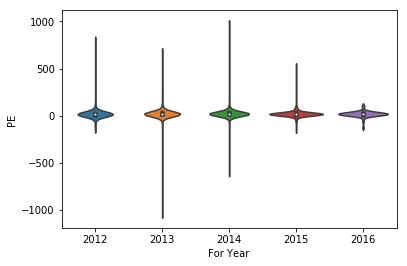

In [127]:
sns.violinplot(data=new_data2,x='For Year',y='PE')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

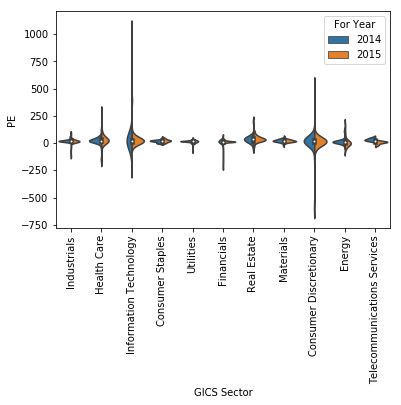

In [128]:
#2014 and 2015 PE
yearsplt = ['2014','2015']
g = sns.violinplot(data=new_data2[new_data2['For Year'].isin(yearsplt)][['PE','GICS Sector','For Year']],
                   x='GICS Sector',y='PE',hue='For Year',split=True)
plt.xticks(rotation=90)

In [129]:
#PE of each sector by year
pd.pivot_table(data=new_data2[['GICS Sector','PE','For Year']],
               index='GICS Sector',columns='For Year',aggfunc='mean', values='PE').sort_values('2015',ascending=False)

For Year,2012,2013,2014,2015,2016
GICS Sector,,,,,
Real Estate,47.463358,63.472894,39.152853,38.998870,NaN
Information Technology,15.077369,23.862120,53.856286,34.636285,19.723825
Health Care,31.477566,17.480947,23.405894,29.742910,23.301350
Consumer Discretionary,36.770008,31.706758,4.485193,26.463242,13.293059
Materials,10.728731,33.530831,21.620047,22.851554,17.272126
Consumer Staples,10.155906,13.813015,16.829215,22.356071,14.465489
Industrials,15.966103,10.378203,25.104518,15.580308,35.356987
Financials,6.735906,16.779605,11.831574,14.989375,0.000000
Energy,48.856246,-8.593349,17.691752,13.235982,-124.629635


In [130]:
pd.pivot_table(data=new_data2[['GICS Sub Industry','PE','For Year']],
               index='GICS Sub Industry',columns='For Year',aggfunc='mean', values='PE').sort_values('2015',ascending=False)

For Year,2012,2013,2014,2015,2016
GICS Sub Industry,,,,,
Internet & Direct Marketing Retail,21.783357,198.427320,-124.330652,159.110772,NaN
Office REITs,43.800001,236.871787,201.728808,110.764709,NaN
Home Furnishings,24.922865,30.637859,21.282192,73.123552,NaN
Biotechnology,-31.161698,34.717074,34.857588,59.879339,NaN
Specialized REITs,41.836295,35.847080,51.104522,57.526040,NaN
Internet Software & Services,16.558710,24.137462,48.267768,53.603404,18.708913
Brewers,NaN,18.112904,26.805754,48.412370,NaN
Oil & Gas Refining & Marketing & Transportation,11.850396,11.970614,9.119352,44.888973,NaN
Construction Materials,-37.716046,175.440935,41.272437,44.449970,NaN


In [391]:
# Add back the columns later
new_data2.drop(['symbol','For Year','date','GICS Sector','GICS Sub Industry'], axis=1,inplace=True)

In [392]:
#use knn to fill in the missing values of cash,quick and current ratios
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
fastknn_data=fast_knn(new_data2.values, k=30)

In [393]:
new_data2 = pd.DataFrame.from_records(fastknn_data, columns = new_data2.columns)
new_data2.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding,open,close,low,high,volume,PE,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,-367000000.0,-5.60,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,-2.410714,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,0.0,-11.25,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,-2.244444,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,0.0,4.02,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,13.340796,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,0.0,11.39,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,3.718174,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,-320000000.0,2.58,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,20.468993,1.0


In [394]:
#add back the columns to the dataframe
new_data2.insert(loc=0, column='symbol', value=symbol_list)
new_data2.insert(loc=74, column='For Year', value=year_list)
new_data2.insert(loc=1, column='date', value=date_list)
new_data2.insert(loc=82, column='GICS Sector', value=sector_list)
new_data2.insert(loc=83, column='GICS Sub Industry', value=sub_industry_list)

In [395]:
new_data2['date']=pd.to_datetime(new_data2['date'])

In [396]:
for col in ['GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].astype('category')
for col in ['GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].cat.codes

In [397]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 86 columns):
symbol                                                 1357 non-null object
date                                                   1357 non-null datetime64[ns]
Accounts Payable                                       1357 non-null float64
Accounts Receivable                                    1357 non-null float64
Add'l income/expense items                             1357 non-null float64
After Tax ROE                                          1357 non-null float64
Capital Expenditures                                   1357 non-null float64
Capital Surplus                                        1357 non-null float64
Cash Ratio                                             1357 non-null float64
Cash and Cash Equivalents                              1357 non-null float64
Changes in Inventories                                 1357 non-null float64
Common Stocks                           

In [398]:
new_data2.shape

(1357, 86)

In [399]:
#save For Classification and Regression Problems
new_data2.to_csv('final_merged_data.csv',date_format='%Y-%m-%d')

### PCA

In [400]:
new_data3=new_data2.iloc[:,2:87]

In [401]:
new_data3.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,1.0


In [402]:
pca_data = new_data3.drop(['open', 'low', 'high'], axis=1)

In [403]:
def fit_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)   
    return pca

In [404]:
pca_naive = fit_pca(pca_data, n_components=20)

In [405]:
def plot_naive_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)

    return ax

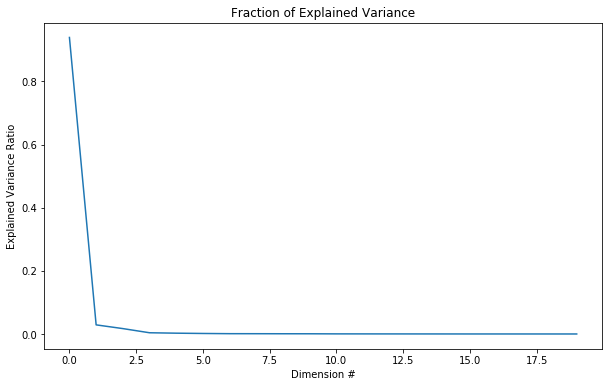

In [406]:
naive_var = plot_naive_variance(pca_naive)

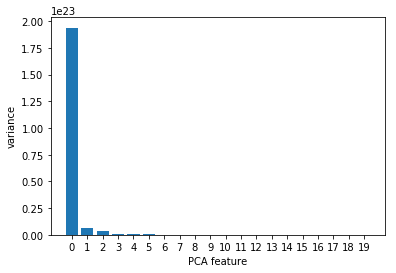

In [407]:
features = range(pca_naive.n_components_)
plt.bar(features, pca_naive.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### Standardized data

In [408]:
def standardize(df):
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)    
    return scaled

In [409]:
scaled = standardize(pca_data)

In [410]:
pca = fit_pca(scaled, n_components=20)

In [411]:
def plot_scaled_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)
       
    return ax

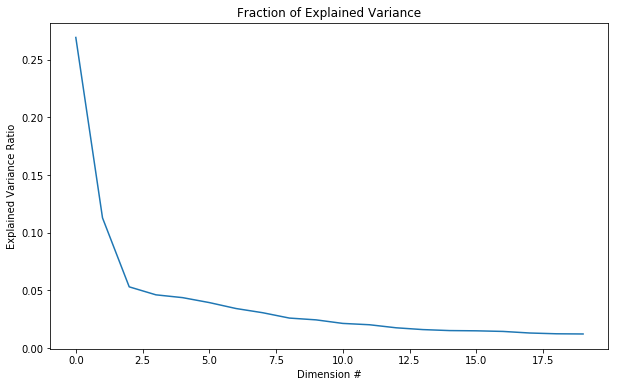

In [412]:
ax = plot_scaled_variance(pca)

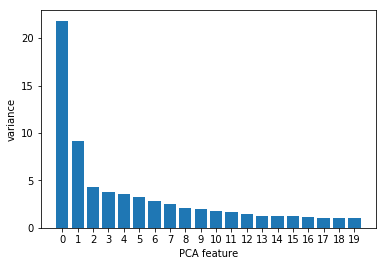

In [413]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [414]:
vars = pca.explained_variance_ratio_
c_names = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
26.9%:     0.18 * f1 +  0.02 * f2 +  0.06 * f3 + -0.01 * f4 + -0.12 * f5 +  0.13 * f6 + -0.01 * f7 +  0.15 * f8 + -0.03 * f9 +  0.10 * f10
11.3%:    -0.11 * f1 + -0.04 * f2 +  0.09 * f3 + -0.00 * f4 + -0.19 * f5 + -0.07 * f6 + -0.03 * f7 + -0.22 * f8 + -0.08 * f9 + -0.08 * f10
 5.3%:    -0.02 * f1 +  0.17 * f2 + -0.01 * f3 +  0.07 * f4 + -0.07 * f5 +  0.10 * f6 +  0.06 * f7 + -0.06 * f8 +  0.04 * f9 +  0.02 * f10
 4.6%:     0.02 * f1 +  0.16 * f2 + -0.06 * f3 + -0.08 * f4 +  0.09 * f5 + -0.04 * f6 + -0.16 * f7 + -0.02 * f8 + -0.04 * f9 +  0.04 * f10
 4.4%:    -0.00 * f1 + -0.07 * f2 + -0.07 * f3 + -0.01 * f4 +  0.16 * f5 + -0.02 * f6 +  0.35 * f7 + -0.01 * f8 + -0.02 * f9 +  0.17 * f10
 3.9%:     0.01 * f1 +  0.15 * f2 +  0.15 * f3 +  0.02 * f4 +  0.01 * f5 + -0.10 * f6 +  0.19 * f7 +  0.06 * f8 +  0.03 * f9 + -0.03 * f10
 3.4%:    -0.11 * f1 +  0.11 * f2 +  0.03 * f3 + -0.05 * f4 + -0.02 * f5 +  0.12 * f6 +  0.19 * f7 + -0.

In [415]:
# 83.5% are explained by PCA 20 features
26.9+11.3+5.3+4.6+4.4+3.9+3.4+3.1+2.6+2.4+2.1+2+1.8+1.6+1.5+1.5+1.4+1.3+1.2+1.2


83.5

In [416]:
reduced = pca.transform(scaled)

In [417]:
scaled.shape

(1357, 81)

In [418]:
reduced.shape

(1357, 20)

In [419]:
new_data2.to_csv('reduced.csv')

In [420]:
# Troy, please use "reduced" to run clustering. 
# Feel free to edit the PCA part, we can drop more columns when create "pca_data".

### Clustering

In [421]:
data00=new_data2.copy()

In [422]:
data00

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,trend
0,AAL,2012-12-31,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.000000,1.330000e+09,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.0
1,AAL,2013-12-31,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.000000,2.175000e+09,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.0
2,AAL,2014-12-31,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.000000,1.768000e+09,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.0
3,AAL,2015-12-31,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.000000,1.085000e+09,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.0
4,ABBV,2013-12-31,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.000000,9.595000e+09,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,1.0
5,ABBV,2014-12-31,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.000000,8.348000e+09,...,1.598198e+09,66.720001,65.440002,65.349998,67.099998,3917300.0,4,87,58.954957,1.0
6,ABBV,2015-12-31,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.000000,8.399000e+09,...,1.633016e+09,59.500000,59.240002,59.200001,59.930000,6019300.0,4,87,18.806350,1.0
7,ABC,2013-09-30,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.000000,1.231006e+09,...,2.306952e+08,60.900002,61.099998,60.689999,61.270000,1040200.0,4,44,32.499999,1.0
8,ABC,2014-09-30,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.000000,1.808513e+09,...,2.247787e+08,77.650002,77.300003,77.190002,78.019997,1373500.0,4,44,63.360658,1.0
9,ABC,2015-09-30,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.000000,2.167442e+09,...,2.228468e+08,96.080002,94.989998,94.070000,96.680000,2381200.0,4,44,-153.209674,0.0


In [423]:
data2012=data00.loc[data00['For Year'] == '2012']
data2013=data00.loc[data00['For Year'] == '2013']
data2014=data00.loc[data00['For Year'] == '2014']
data2015=data00.loc[data00['For Year'] == '2015']
data2016=data00.loc[data00['For Year'] == '2016']

In [424]:
names2012 = data2012['symbol'].values.tolist()
from collections import OrderedDict
names2012 = list(OrderedDict.fromkeys(names2012))

names2013 = data2013['symbol'].values.tolist()
names2013 = list(OrderedDict.fromkeys(names2013))

names2014 = data2014['symbol'].values.tolist()
names2014 = list(OrderedDict.fromkeys(names2014))

names2015 = data2015['symbol'].values.tolist()
names2015 = list(OrderedDict.fromkeys(names2015))

names2016 = data2016['symbol'].values.tolist()
names2016 = list(OrderedDict.fromkeys(names2016))

In [425]:
data2012 = data2012.drop(['symbol', 'date','For Year','trend'], axis=1)
data2013 = data2013.drop(['symbol', 'date','For Year','trend'], axis=1)
data2014 = data2014.drop(['symbol', 'date','For Year','trend'], axis=1)
data2015 = data2015.drop(['symbol', 'date','For Year','trend'], axis=1)
data2016 = data2016.drop(['symbol', 'date','For Year','trend'], axis=1)

## t-SNE before PCA:

### t-SNE for 2012 before PCA

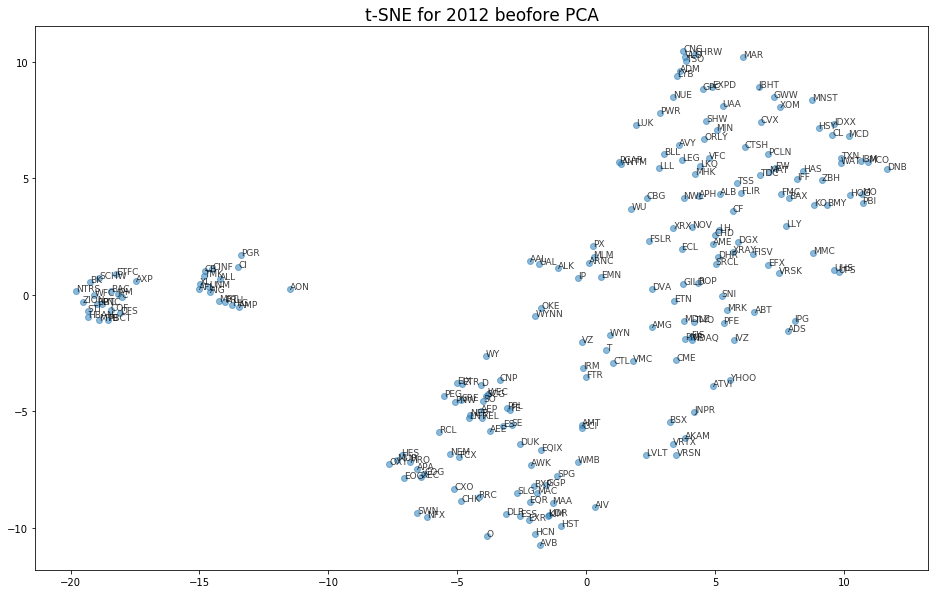

In [426]:
from sklearn.preprocessing import normalize

data2012s = data2012.values
normalized_2012 = normalize(data2012s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2012)

# Select the 0th feature: xs
xs2012 = tsne_features[:,0]

# Select the 1th feature: ys
ys2012 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2012, ys2012, alpha=0.5)
# Annotate the points
for x0, y0, company in zip(xs2012, ys2012, names2012):
    plt.annotate(company, (x0, y0), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2012 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2013 before PCA

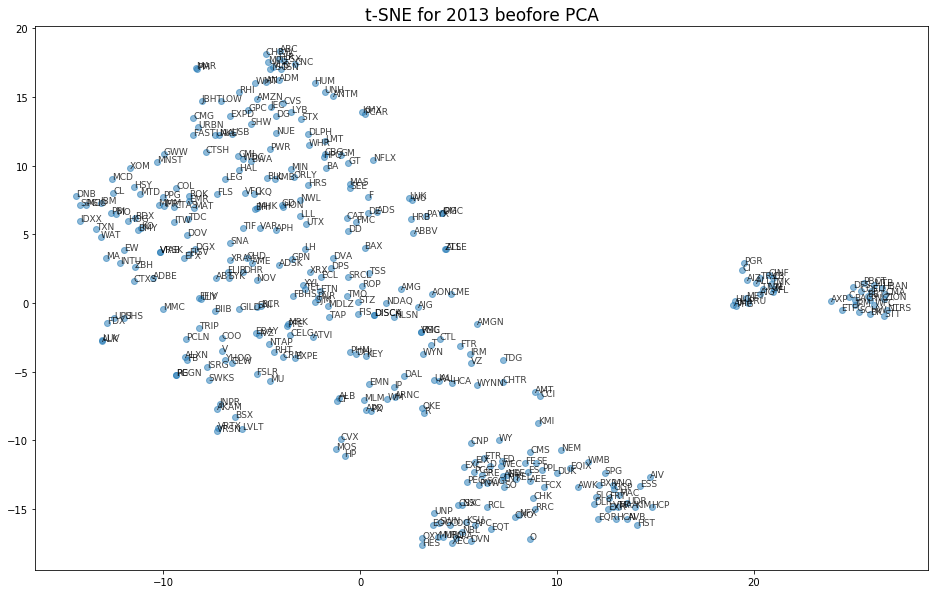

In [522]:
from sklearn.preprocessing import normalize

data2013s = data2013.values
normalized_2013 = normalize(data2013s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2013)

# Select the 0th feature: xs
xs2013 = tsne_features[:,0]

# Select the 1th feature: ys
ys2013 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2013, ys2013, alpha=0.5)
# Annotate the points
for x1, y1, company in zip(xs2013, ys2013, names2013):
    plt.annotate(company, (x1, y1), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2013 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2014 before PCA

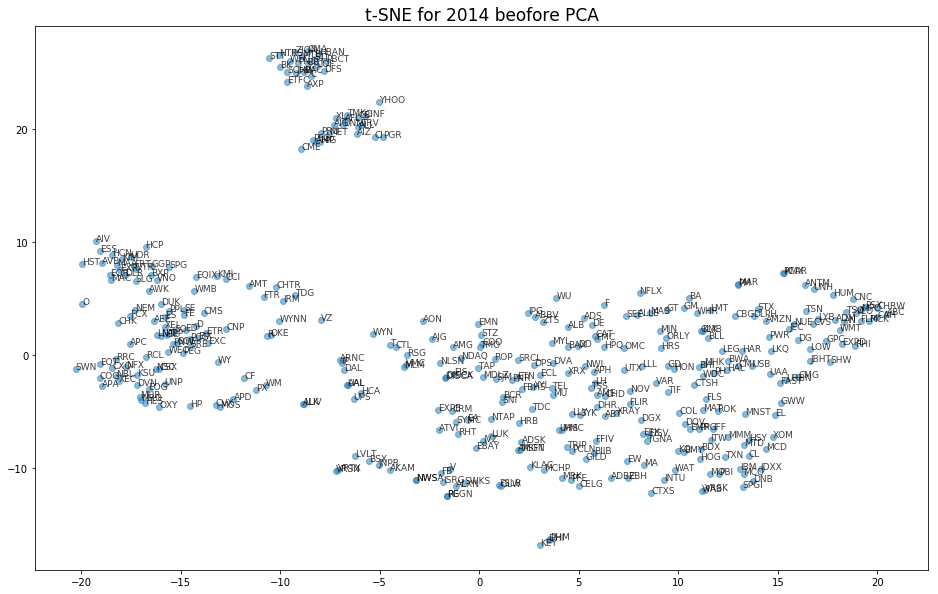

In [428]:
from sklearn.preprocessing import normalize

data2014s = data2014.values
normalized_2014 = normalize(data2014s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2014)

# Select the 0th feature: xs
xs2014 = tsne_features[:,0]

# Select the 1th feature: ys
ys2014 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2014, ys2014, alpha=0.5)
# Annotate the points
for x2, y2, company in zip(xs2014, ys2014, names2014):
    plt.annotate(company, (x2, y2), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2014 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2015 before PCA

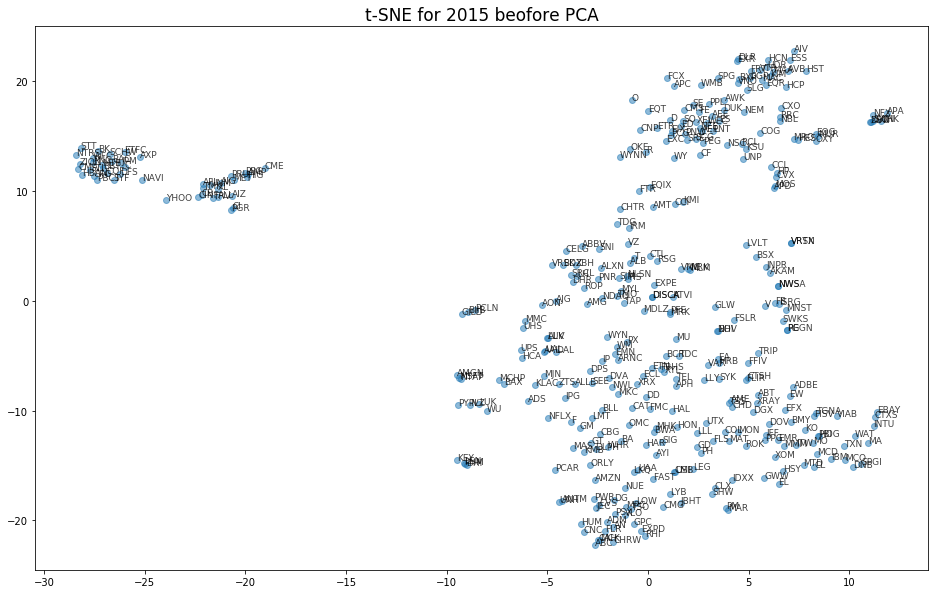

In [429]:
from sklearn.preprocessing import normalize

data2015s = data2015.values
normalized_2015 = normalize(data2015s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2015)

# Select the 0th feature: xs
xs2015 = tsne_features[:,0]

# Select the 1th feature: ys
ys2015 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2015, ys2015, alpha=0.5)
# Annotate the points
for x3, y3, company in zip(xs2015, ys2015, names2015):
    plt.annotate(company, (x3, y3), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2015 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2016 before PCA

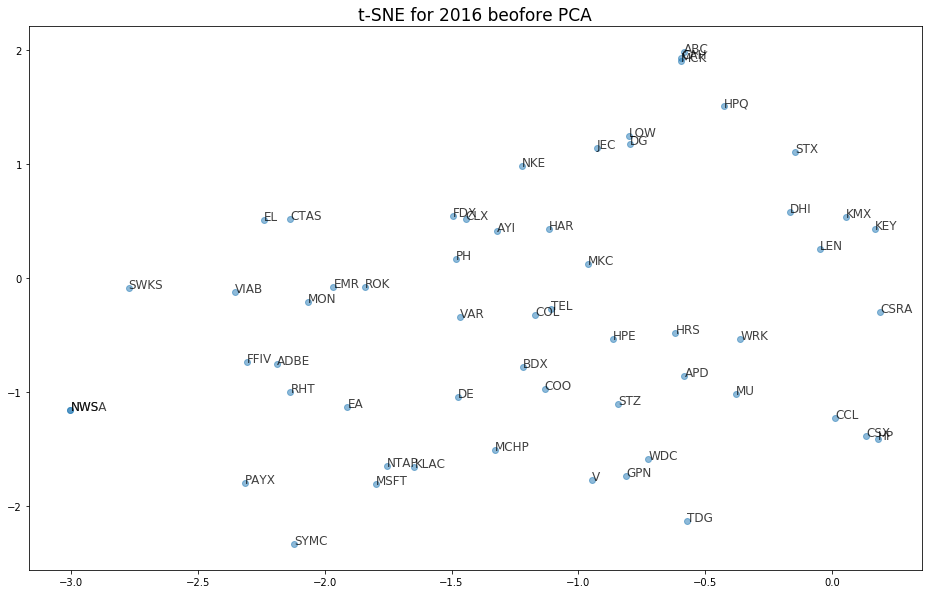

In [430]:
from sklearn.preprocessing import normalize

data2016s = data2016.values
normalized_2016 = normalize(data2016s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50,perplexity=40)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2016)

# Select the 0th feature: xs
xs2016 = tsne_features[:,0]

# Select the 1th feature: ys
ys2016 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2016, ys2016, alpha=0.5)
# Annotate the points
for x4, y4, company in zip(xs2016, ys2016, names2016):
    plt.annotate(company, (x4, y4), fontsize=12, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2016 beofore PCA',fontsize=17)
plt.show()

## t-SNE after PCA:

In [431]:
df00=new_data2.copy()

In [432]:
df11 = pd.DataFrame(data=reduced)
#x21 = df11.iloc[:,0:19].values
df11['Year'] = df00['For Year']
df11['symbol']=df00['symbol']
#df11

In [433]:
pca2012=df11.loc[df11['Year'] == '2012']
pca2013=df11.loc[df11['Year'] == '2013']
pca2014=df11.loc[df11['Year'] == '2014']
pca2015=df11.loc[df11['Year'] == '2015']
pca2016=df11.loc[df11['Year'] == '2016']

In [434]:
pcaname2012 = pca2012['symbol'].values.tolist()
from collections import OrderedDict
pcaname2012 = list(OrderedDict.fromkeys(pcaname2012))

pcaname2013 = pca2013['symbol'].values.tolist()
pcaname2013 = list(OrderedDict.fromkeys(pcaname2013))

pcaname2014 = pca2014['symbol'].values.tolist()
pcaname2014 = list(OrderedDict.fromkeys(pcaname2014))

pcaname2015 = pca2015['symbol'].values.tolist()
pcaname2015 = list(OrderedDict.fromkeys(pcaname2015))

pcaname2016 = pca2016['symbol'].values.tolist()
pcaname2016 = list(OrderedDict.fromkeys(pcaname2016))

pca2012 = pca2012.drop(['symbol','Year'], axis=1)
pca2013 = pca2013.drop(['symbol','Year'], axis=1)
pca2014 = pca2014.drop(['symbol','Year'], axis=1)
pca2015 = pca2015.drop(['symbol','Year'], axis=1)
pca2016 = pca2016.drop(['symbol','Year'], axis=1)
#pcaname2012

### t-SNE for 2012 after PCA

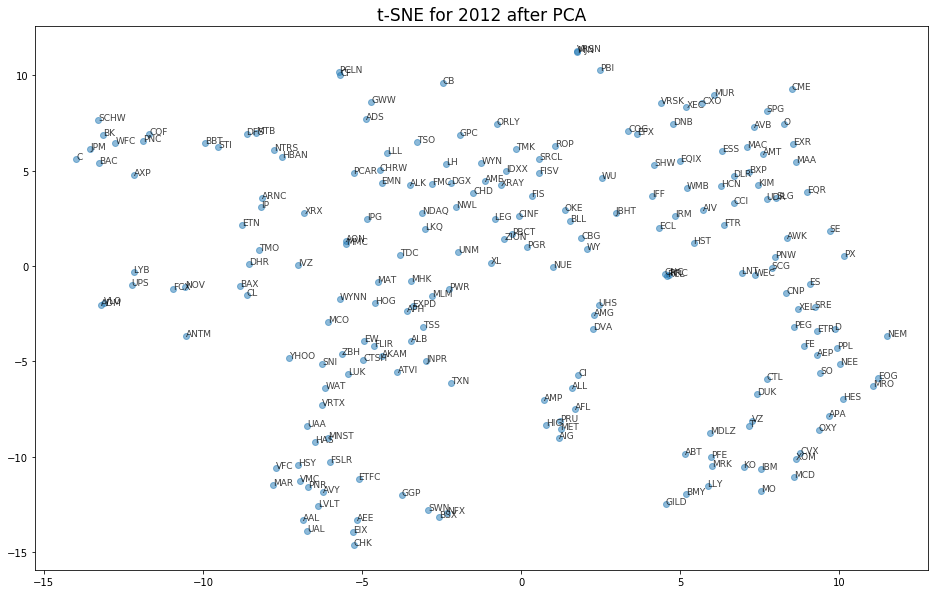

In [435]:
from sklearn.preprocessing import normalize

pca2012s = pca2012.values
normalized_2012pca = normalize(pca2012s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2012pca)

# Select the 0th feature: xs
xs2012pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2012pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2012pca, ys2012pca, alpha=0.5)
# Annotate the points
for x00, y00, company in zip(xs2012pca, ys2012pca, pcaname2012):
    plt.annotate(company, (x00, y00), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2012 after PCA',fontsize=17)
plt.show()

### t-SNE for 2013 after PCA

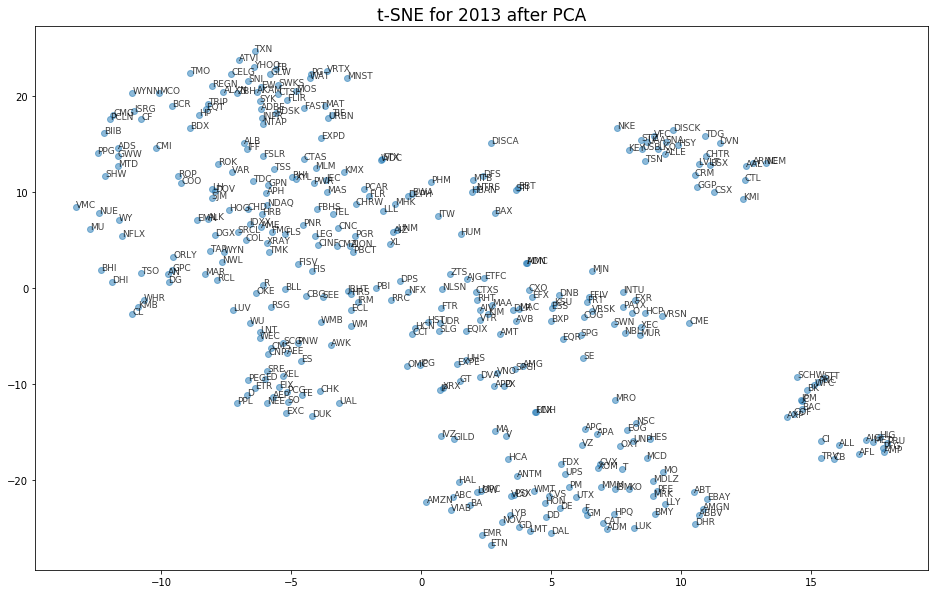

In [436]:
pca2013s = pca2013.values
normalized_2013pca = normalize(pca2013s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2013pca)

# Select the 0th feature: xs
xs2013pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2013pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2013pca, ys2013pca, alpha=0.5)
# Annotate the points
for x11, y11, company in zip(xs2013pca, ys2013pca, pcaname2013):
    plt.annotate(company, (x11, y11), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2013 after PCA',fontsize=17)
plt.show()

### t-SNE for 2014 after PCA

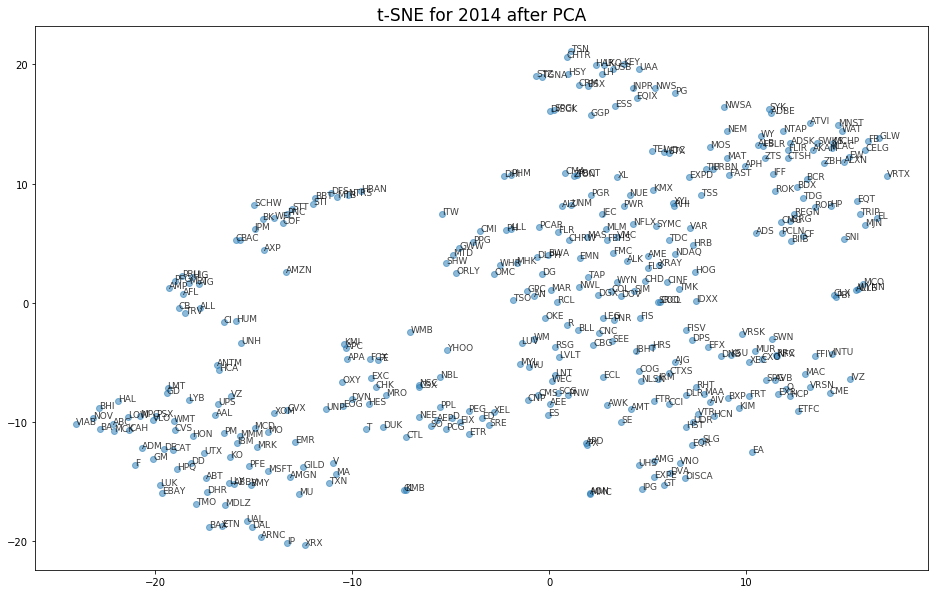

In [437]:
pca2014s = pca2014.values
normalized_2014pca = normalize(pca2014s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2014pca)

# Select the 0th feature: xs
xs2014pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2014pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2014pca, ys2014pca, alpha=0.5)
# Annotate the points
for x22, y22, company in zip(xs2014pca, ys2014pca, pcaname2014):
    plt.annotate(company, (x22, y22), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2014 after PCA',fontsize=17)
plt.show()

### t-SNE for 2015 after PCA

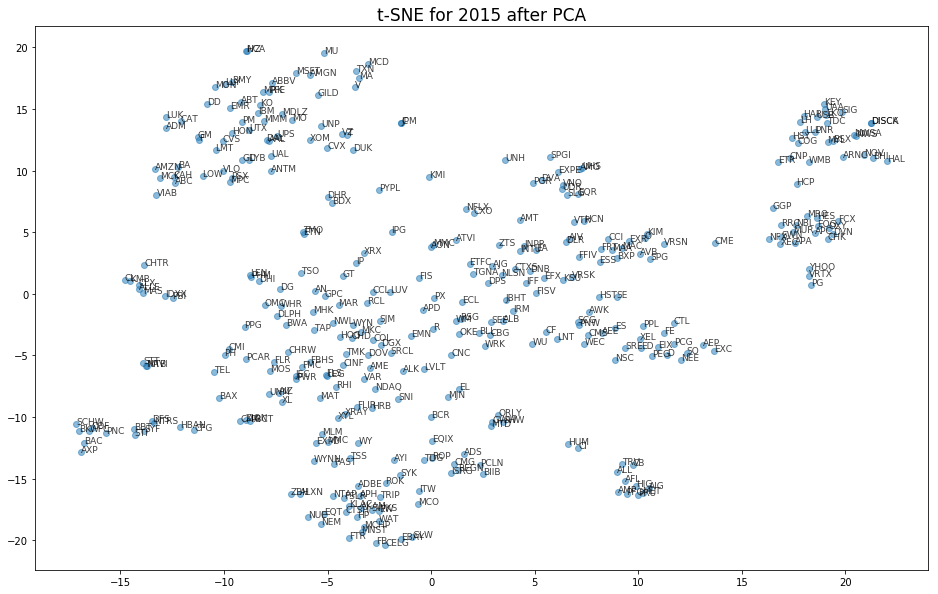

In [438]:
pca2015s = pca2015.values
normalized_2015pca = normalize(pca2015s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2015pca)

# Select the 0th feature: xs
xs2015pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2015pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2015pca, ys2015pca, alpha=0.5)
# Annotate the points
for x33, y33, company in zip(xs2015pca, ys2015pca, pcaname2015):
    plt.annotate(company, (x33, y33), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2015 after PCA',fontsize=17)
plt.show()

### t-SNE for 2016 after PCA

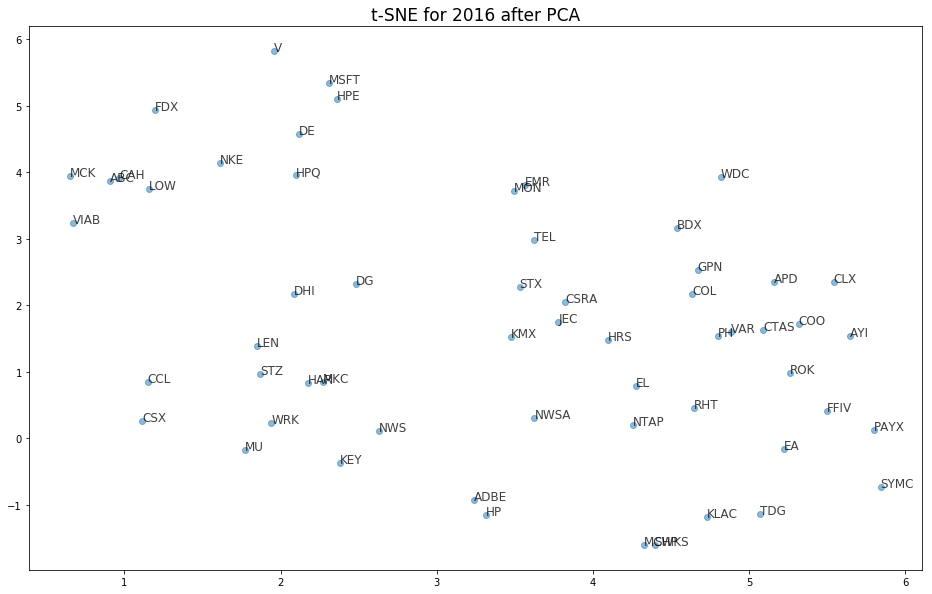

In [439]:
pca2016s = pca2016.values
normalized_2016pca = normalize(pca2016s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2016pca)

# Select the 0th feature: xs
xs2016pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2016pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2016pca, ys2016pca, alpha=0.5)
# Annotate the points
for x44, y44, company in zip(xs2016pca, ys2016pca, pcaname2016):
    plt.annotate(company, (x44, y44), fontsize=12, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2016 after PCA',fontsize=17)
plt.show()

## K-means before PCA

### K-means for 2012 before PCA

In [440]:
#import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

x2012 = data2012.iloc[:,0:82].values

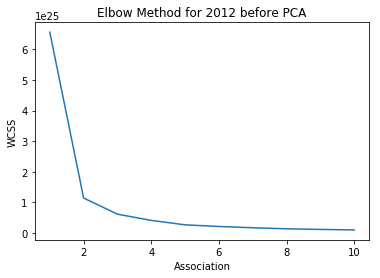

In [441]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2012)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2012 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182

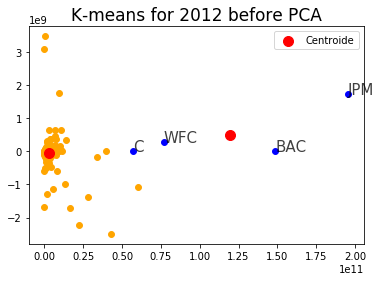

In [445]:
#k = 3
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2012 = kmeans.fit_predict(x2012)

plt.scatter(x2012[y_kmeans2012 == 0, 0], x2012[y_kmeans2012 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2012[y_kmeans2012 == 1, 0], x2012[y_kmeans2012 == 1, 1], s = 35, 
            c = 'blue')
#plt.scatter(x2012[y_kmeans2012 == 2, 0], x2012[y_kmeans2012 == 2, 1], s = 35, 
#            c = 'green')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')
xk1=x2012[y_kmeans2012 == 1, 0]
yk1=x2012[y_kmeans2012 == 1, 1]
mydict1 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict1)
l1 = [names2012[i] for i in (27,35,107,200)]
for x, y, company in zip(xk1, yk1, l1):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)
plt.title('K-means for 2012 before PCA',fontsize=17)
plt.legend()

### K-means for 2013 before PCA

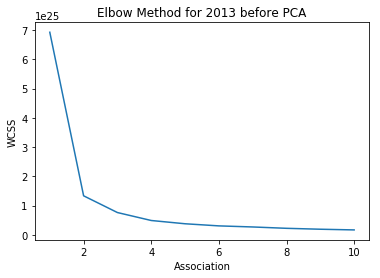

In [446]:
x2013 = data2013.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2013)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2013 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181

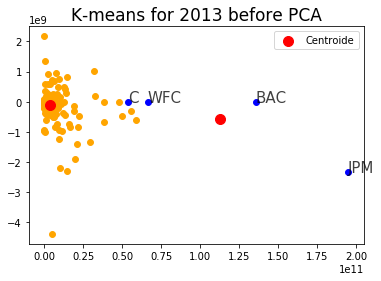

In [447]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2013 = kmeans.fit_predict(x2013)

plt.scatter(x2013[y_kmeans2013 == 0, 0], x2013[y_kmeans2013 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2013[y_kmeans2013 == 1, 0], x2013[y_kmeans2013 == 1, 1], s = 35, 
            c = 'blue')


#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

xk2=x2013[y_kmeans2013 == 1, 0]
yk2=x2013[y_kmeans2013 == 1, 1]
mydict2 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict2)
l2 = [names2013[i] for i in (40,  53, 182, 338)]
for x, y, company in zip(xk2, yk2, l2):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

plt.title('K-means for 2013 before PCA',fontsize=17)
plt.legend()

### K-means for 2014 before PCA

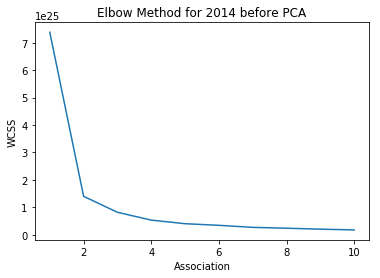

In [448]:
x2014 = data2014.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2014)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2014 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [449]:
names2014[40]

'BAC'

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181

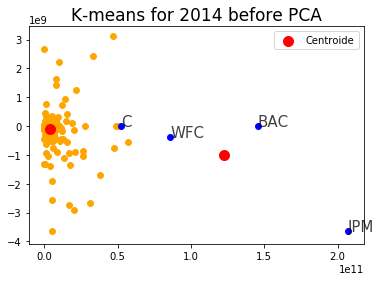

In [450]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2014 = kmeans.fit_predict(x2014)

plt.scatter(x2014[y_kmeans2014 == 0, 0], x2014[y_kmeans2014 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2014[y_kmeans2014 == 1, 0], x2014[y_kmeans2014 == 1, 1], s = 35, 
            c = 'blue')


#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

xk3=x2014[y_kmeans2014 == 1, 0]
yk3=x2014[y_kmeans2014 == 1, 1]
mydict3 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict3)
l3 = [names2014[i] for i in (40,  53, 184, 346)]
for x, y, company in zip(xk3, yk3, l3):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

plt.title('K-means for 2014 before PCA',fontsize=17)
plt.legend()

### K-means for 2015 before PCA

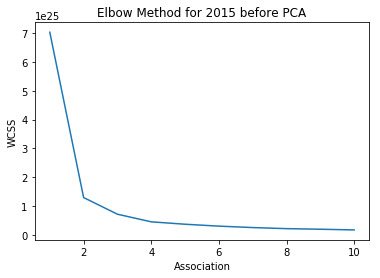

In [451]:
x2015 = data2015.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2015)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2015 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182

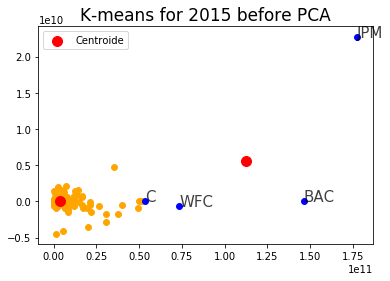

In [452]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2015 = kmeans.fit_predict(x2015)

plt.scatter(x2015[y_kmeans2015 == 0, 0], x2015[y_kmeans2015 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2015[y_kmeans2015 == 1, 0], x2015[y_kmeans2015 == 1, 1], s = 35, 
            c = 'blue')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

xk4=x2015[y_kmeans2015 == 1, 0]
yk4=x2015[y_kmeans2015 == 1, 1]
mydict4 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict4)
l4 = [names2015[i] for i in (40,  53, 180, 340)]
for x, y, company in zip(xk4, yk4, l4):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

plt.title('K-means for 2015 before PCA',fontsize=17)
plt.legend()

### K-means for 2016 before PCA

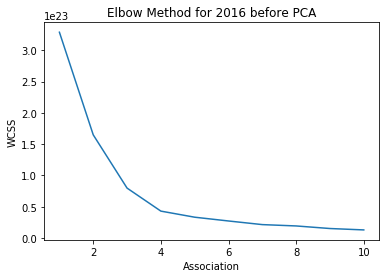

In [453]:
x2016 = data2016.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2016)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2016 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([ 0,  5, 24, 34, 37]), 1: array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57])}


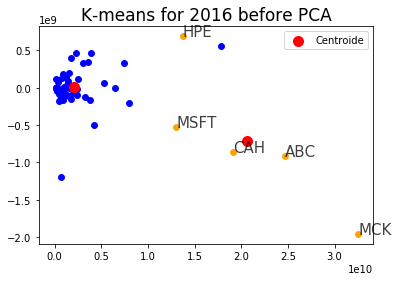

In [454]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2016 = kmeans.fit_predict(x2016)

plt.scatter(x2016[y_kmeans2016 == 0, 0], x2016[y_kmeans2016 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2016[y_kmeans2016 == 1, 0], x2016[y_kmeans2016 == 1, 1], s = 35, 
            c = 'blue')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

xk5=x2016[y_kmeans2016 == 0, 0]
yk5=x2016[y_kmeans2016 == 0, 1]
mydict5 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict5)
l5 = [names2016[i] for i in (0,  5, 24, 34, 37)]
for x, y, company in zip(xk5, yk5, l5):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

plt.title('K-means for 2016 before PCA',fontsize=17)
plt.legend()

## K-means after PCA

### K-means for 2012 after PCA

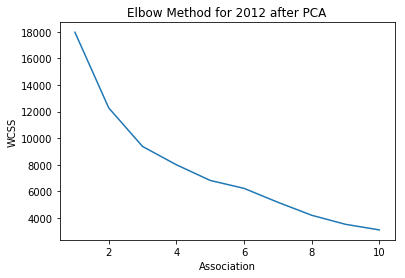

In [455]:
xx2012 = pca2012.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2012)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2012 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184

Text(0.5, 1.0, 'K-means for 2012 after PCA')

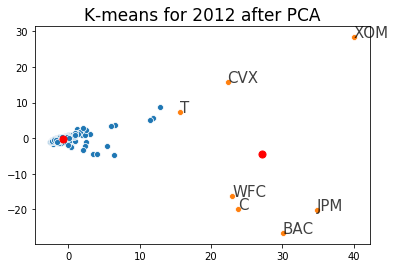

In [456]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans12 = kmeans.fit_predict(xx2012)

for i in range(0,2):
    sns.scatterplot(xx2012[y_kmeans12 == i, 0], xx2012[y_kmeans12 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

xk6=xx2012[y_kmeans12 == 1, 0]
yk6=xx2012[y_kmeans12 == 1, 1]
mydict6 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict6)
l6 = [pcaname2012[i] for i in (27,  35,  53, 107, 178, 200, 209)]
for x, y, company in zip(xk6, yk6, l6):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

plt.title('K-means for 2012 after PCA',fontsize=17)

### K-means for 2013 after PCA

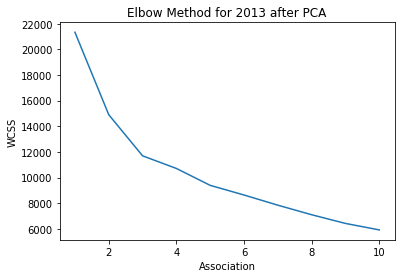

In [512]:
xx2013 = pca2013.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2013)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2013 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([ 85, 127, 148, 169, 253, 298, 334, 342, 350]), 1: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174,
   

Text(0.5, 1.0, 'K-means for 2013 after PCA')

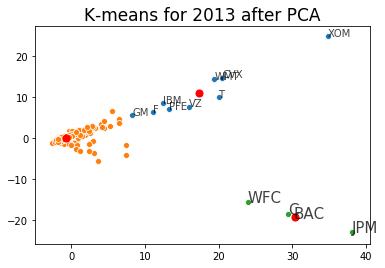

In [513]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans13 = kmeans.fit_predict(xx2013)

for i in range(0,3):
    sns.scatterplot(xx2013[y_kmeans13 == i, 0], xx2013[y_kmeans13 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

xk7=xx2013[y_kmeans13 == 2, 0]
yk7=xx2013[y_kmeans13 == 2, 1]
mydict7 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict7)
l7 = [pcaname2013[i] for i in (40,  53, 182, 338)]
for x, y, company in zip(xk7, yk7, l7):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

xk77=xx2013[y_kmeans13 == 0, 0]
yk77=xx2013[y_kmeans13 == 0, 1]
l77 = [pcaname2013[i] for i in (85, 127, 148, 169, 253, 298, 334, 342, 350)]
for x, y, company in zip(xk77, yk77, l77):
    plt.annotate(company, (x, y), fontsize=10, alpha=0.75)

plt.title('K-means for 2013 after PCA',fontsize=17)

### K-means for 2014 after PCA

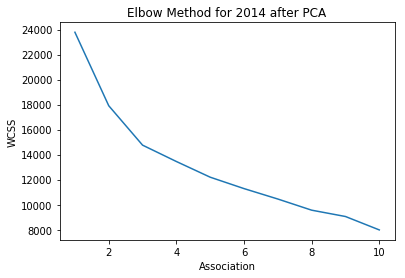

In [514]:
xx2014 = pca2014.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2014)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2014 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187

Text(0.5, 1.0, 'K-means for 2014 after PCA')

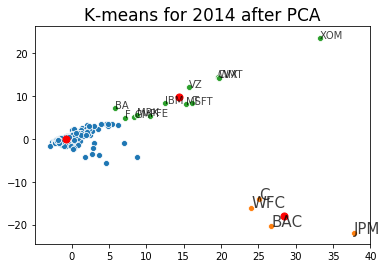

In [515]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans14 = kmeans.fit_predict(xx2014)

for i in range(0,3):
    sns.scatterplot(xx2014[y_kmeans14 == i, 0], xx2014[y_kmeans14 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

xk8=xx2014[y_kmeans14 == 2, 0]
yk8=xx2014[y_kmeans14 == 2, 1]
mydict8 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict8)
l8 = [pcaname2014[i] for i in (39,  86, 130, 150, 171, 
                               226, 228, 260, 306, 342, 350, 358)]
for x, y, company in zip(xk8, yk8, l8):
    plt.annotate(company, (x, y), fontsize=10, alpha=0.75)

xk88=xx2014[y_kmeans14 == 1, 0]
yk88=xx2014[y_kmeans14 == 1, 1]
l88 = [pcaname2014[i] for i in (40,  53, 184, 346)]
for x, y, company in zip(xk88, yk88, l88):
    plt.annotate(company, (x, y), fontsize=15, alpha=0.75)

plt.title('K-means for 2014 after PCA',fontsize=17)

### K-means for 2015 after PCA

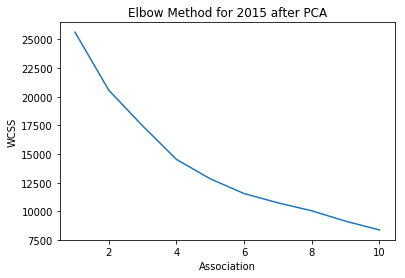

In [516]:
xx2015 = pca2015.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2015)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2015 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([ 40,  53,  85, 128, 148, 167, 180, 226, 259, 304, 337, 340, 352]), 1: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 168, 169, 170, 171

Text(0.5, 1.0, 'K-means for 2015 after PCA')

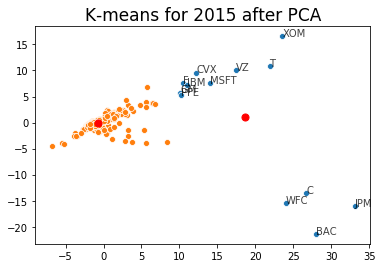

In [517]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans15 = kmeans.fit_predict(xx2015)

for i in range(0,2):
    sns.scatterplot(xx2015[y_kmeans15 == i, 0], xx2015[y_kmeans15 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

xk9=xx2015[y_kmeans15 == 0, 0]
yk9=xx2015[y_kmeans15 == 0, 1]
mydict9 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict9)
l9 = [pcaname2015[i] for i in ( 40,  53,  85, 128, 148, 167, 
                               180, 226, 259, 304, 337, 340, 352)]
for x, y, company in zip(xk9, yk9, l9):
    plt.annotate(company, (x, y), fontsize=10, alpha=0.75)

plt.title('K-means for 2015 after PCA',fontsize=17)

### K-means for 2016 after PCA

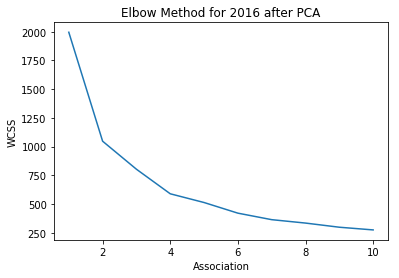

In [518]:
xx2016 = pca2016.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2016)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2016 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

{0: array([ 0,  5, 32, 34, 55]), 1: array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56,
       57]), 2: array([37])}


Text(0.5, 1.0, 'K-means for 2016 after PCA')

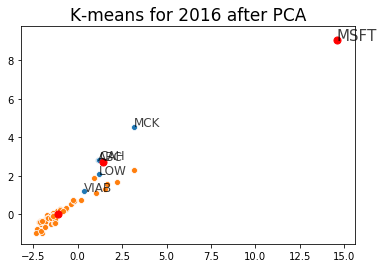

In [519]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans16 = kmeans.fit_predict(xx2016)

for i in range(0,3):
    sns.scatterplot(xx2016[y_kmeans16 == i, 0], xx2016[y_kmeans16 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

xk10=xx2016[y_kmeans16 == 0, 0]
yk10=xx2016[y_kmeans16 == 0, 1]
mydict10 = {i:np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict10)
l10 = [pcaname2016[i] for i in ( 0,  5, 32, 34, 55)]
for x, y, company in zip(xk10, yk10, l10):
    plt.annotate(company, (x, y), fontsize=12, alpha=0.75)

xk101=xx2016[y_kmeans16 == 2, 0]
yk101=xx2016[y_kmeans16 == 2, 1]

plt.annotate(pcaname2016[37], (xk101, yk101), fontsize=15, alpha=0.75)

plt.title('K-means for 2016 after PCA',fontsize=17)

## DBSCAN before PCA

### DBSCAN for 2012 before PCA

Text(0.5, 1.0, 'DBSCAN for 2012 before PCA')

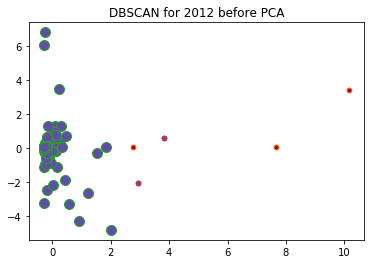

In [597]:
from sklearn.preprocessing import StandardScaler

bp2012 = data2012.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2012)
st2012 = stscaler.transform(bp2012)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.3, min_samples = 5).fit(st2012)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2012[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2012[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
    
plt.title("DBSCAN for 2012 before PCA")

### DBSCAN for 2013 before PCA

Text(0.5, 1.0, 'DBSCAN for 2013 before PCA')

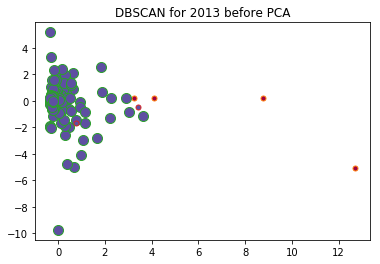

In [598]:
from sklearn.preprocessing import StandardScaler

bp2013 = data2013.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2013)
st2013 = stscaler.transform(bp2013)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 28.5, min_samples = 5).fit(st2013)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2013[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2013[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2013 before PCA")

### DBSCAN for 2014 before PCA

Text(0.5, 1.0, 'DBSCAN for 2014 before PCA')

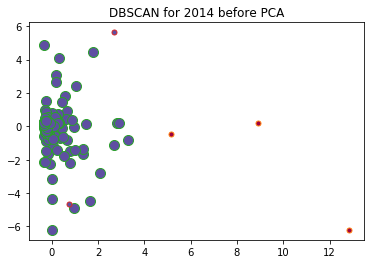

In [599]:
from sklearn.preprocessing import StandardScaler

bp2014 = data2014.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2014)
st2014 = stscaler.transform(bp2014)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 29.6, min_samples = 5).fit(st2014)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2014[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2014[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2014 before PCA")

### DBSCAN for 2015 before PCA

Text(0.5, 1.0, 'DBSCAN for 2015 before PCA')

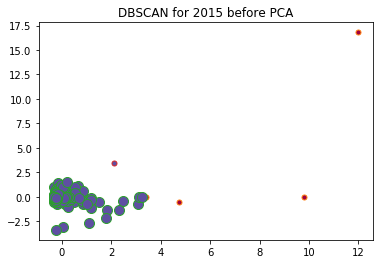

In [600]:
from sklearn.preprocessing import StandardScaler

bp2015 = data2015.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2015)
st2015 = stscaler.transform(bp2015)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30, min_samples = 5).fit(st2015)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2015[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2015[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2015 before PCA")

### DBSCAN for 2016 before PCA

Text(0.5, 1.0, 'DBSCAN for 2016 before PCA')

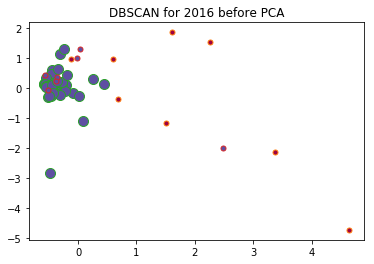

In [601]:
from sklearn.preprocessing import StandardScaler

bp2016 = data2016.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2016)
st2016 = stscaler.transform(bp2016)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 9.9, min_samples = 20).fit(st2016)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2016[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2016[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2016 before PCA")

## DBSCAN after PCA

### DBSCAN for 2012 after PCA

Text(0.5, 1.0, 'DBSCAN for 2012 after PCA')

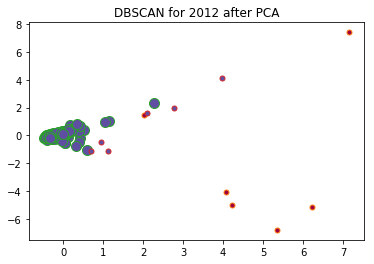

In [610]:
ap2012 = pca2012.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2012)
stp2012 = stscaler.transform(ap2012)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 8.9, min_samples = 12).fit(stp2012)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2012[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2012[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2012 after PCA")

### DBSCAN for 2013 after PCA

Text(0.5, 1.0, 'DBSCAN for 2013 after PCA')

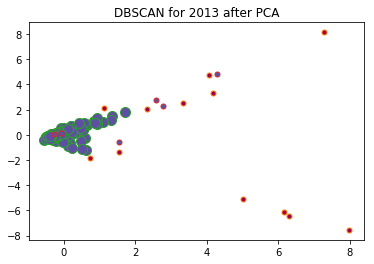

In [603]:
ap2013 = pca2013.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2013)
stp2013 = stscaler.transform(ap2013)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 8.8, min_samples = 15).fit(stp2013)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2013[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2013[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2013 after PCA")

### DBSCAN for 2014 after PCA

Text(0.5, 1.0, 'DBSCAN for 2014 after PCA')

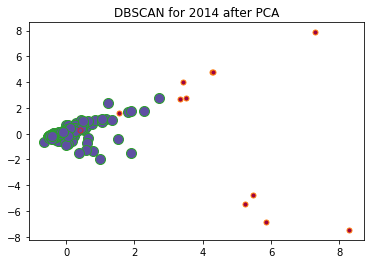

In [604]:
ap2014 = pca2014.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2014)
stp2014 = stscaler.transform(ap2014)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 8.6, min_samples = 3).fit(stp2014)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2014[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2014[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2014 after PCA")

### DBSCAN for 2015 after PCA

Text(0.5, 1.0, 'DBSCAN for 2015 after PCA')

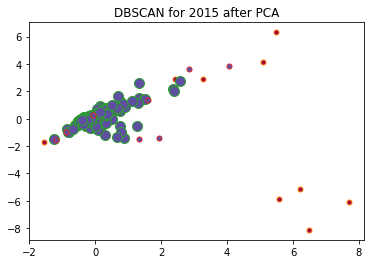

In [605]:
ap2015 = pca2015.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2015)
stp2015 = stscaler.transform(ap2015)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 9.8, min_samples = 30).fit(stp2015)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2015[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2015[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2015 after PCA")

### DBSCAN for 2016 after PCA

Text(0.5, 1.0, 'DBSCAN for 2016 after PCA')

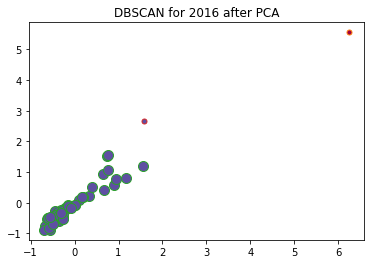

In [606]:
ap2016 = pca2016.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2016)
stp2016 = stscaler.transform(ap2016)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2016)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2016[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2016[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2016 after PCA")

## Hierarchical Clustering before PCA

### HC for 2012 before PCA

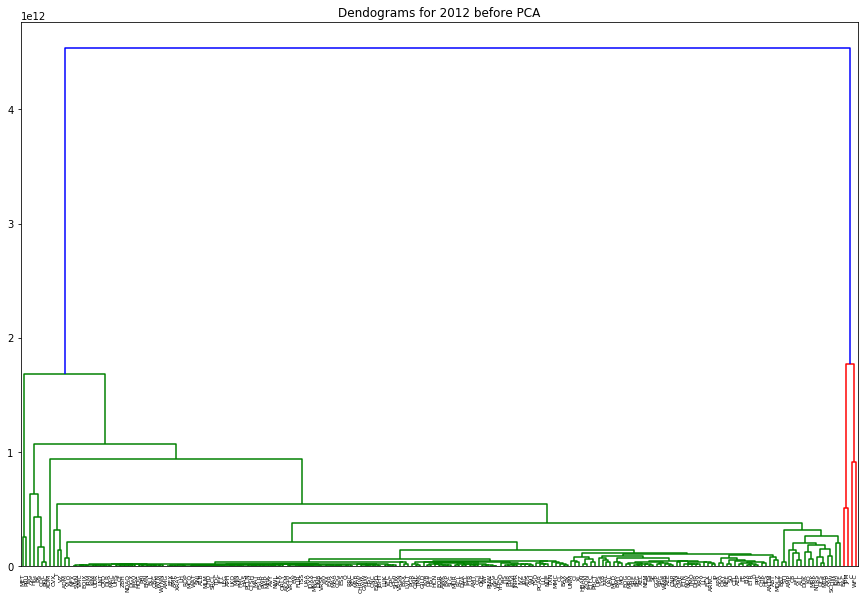

['AAL', 'ABT', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AKAM', 'ALB', 'ALK', 'ALL', 'AME', 'AMG', 'AMP', 'AMT', 'ANTM', 'AON', 'APA', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'BAC', 'BAX', 'BBT', 'BK', 'BLL', 'BMY', 'BSX', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CF', 'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CME', 'CNC', 'CNP', 'COF', 'COG', 'CTL', 'CTSH', 'CVX', 'CXO', 'D', 'DFS', 'DGX', 'DHR', 'DLR', 'DNB', 'DUK', 'DVA', 'ECL', 'EFX', 'EIX', 'EMN', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'FCX', 'FE', 'FIS', 'FISV', 'FLIR', 'FMC', 'FSLR', 'FTR', 'GGP', 'GILD', 'GPC', 'GWW', 'HAS', 'HBAN', 'HCN', 'HES', 'HIG', 'HOG', 'HST', 'HSY', 'IBM', 'IDXX', 'IFF', 'IP', 'IPG', 'IRM', 'IVZ', 'JBHT', 'JNPR', 'JPM', 'KIM', 'KO', 'LEG', 'LH', 'LKQ', 'LLL', 'LLY', 'LNT', 'LUK', 'LVLT', 'LYB', 'MAA', 'MAC', 'MAR', 'MAT', 'MCD', 'MCO', 'MDLZ', 'MET', 'MHK', 'MJN', 'MLM', 'MMC', 'MNST', 'MO', 'MRK', 'MRO', 'MTB', 'MUR', 'NDAQ', 'NEE', 'NEM', 'NFX', 'NOV',

In [475]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp12 = data2012.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2012 before PCA")
mergings = linkage(hcbp12, method='complete')#ward)
labels=names2012
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2012,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [476]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp12) 

array([3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3])

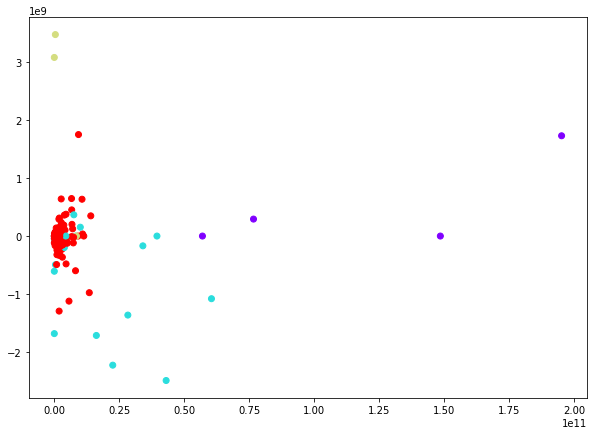

In [477]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp12[:,0], hcbp12[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2013 before PCA

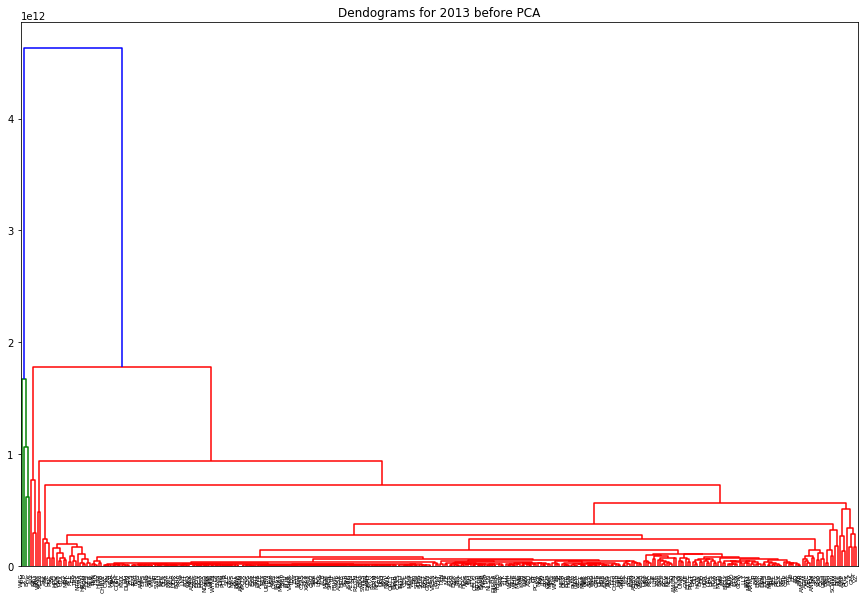

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC',

In [478]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp13 = data2013.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2013 before PCA")
mergings = linkage(hcbp13, method='complete')#ward)
labels=names2013
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2013,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [479]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp13) 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

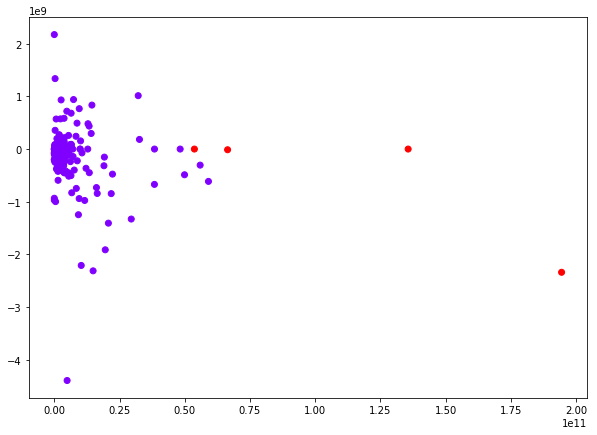

In [480]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp13[:,0], hcbp13[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2014 before PCA

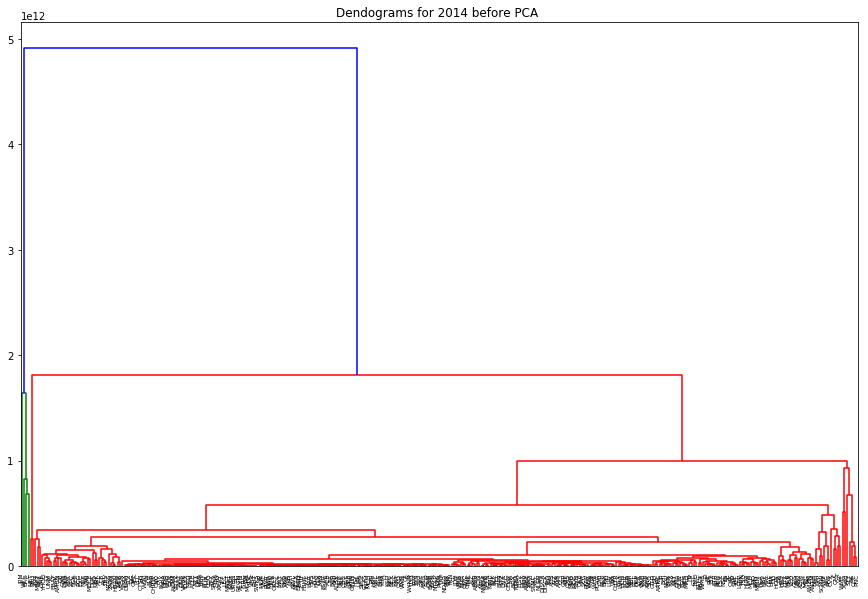

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'F

In [481]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp14 = data2014.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2014 before PCA ")
mergings = linkage(hcbp14, method='complete')#ward)
labels=names2014
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2014,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [482]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp14) 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

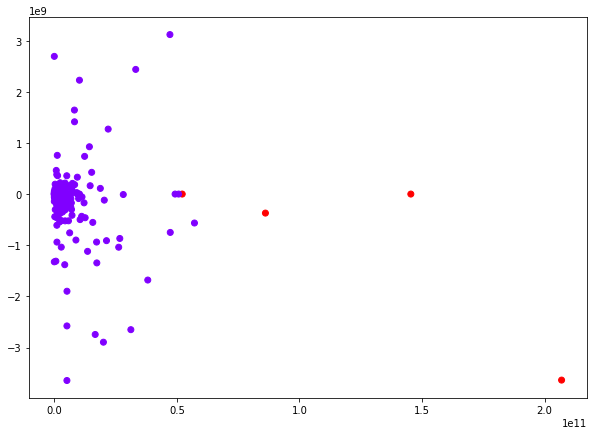

In [483]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp14[:,0], hcbp14[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2015 before PCA

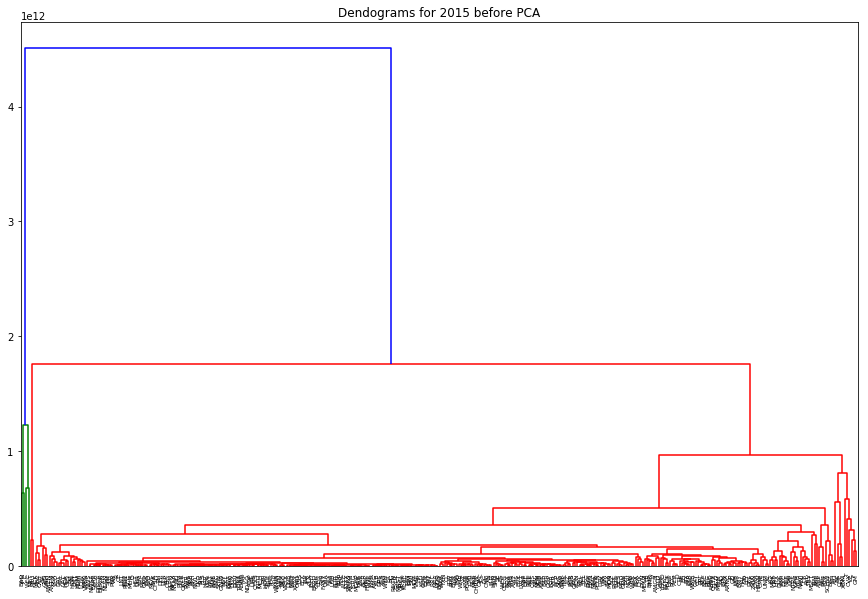

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CCL', 'CELG', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC', 'F

In [484]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp15 = data2015.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2015 before PCA")
mergings = linkage(hcbp15, method='complete')#ward)
labels=names2015
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2015,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [485]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp15) 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

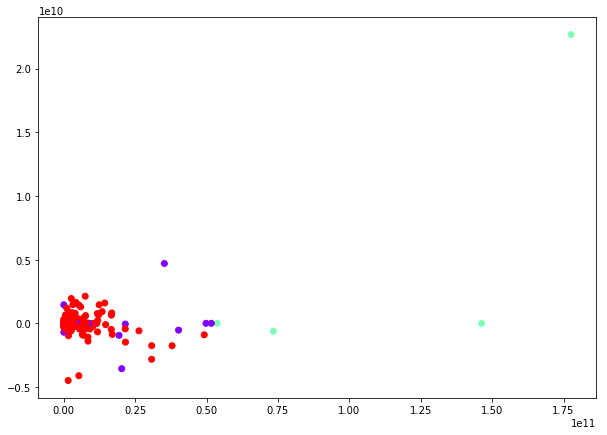

In [486]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp15[:,0], hcbp15[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2016 before PCA

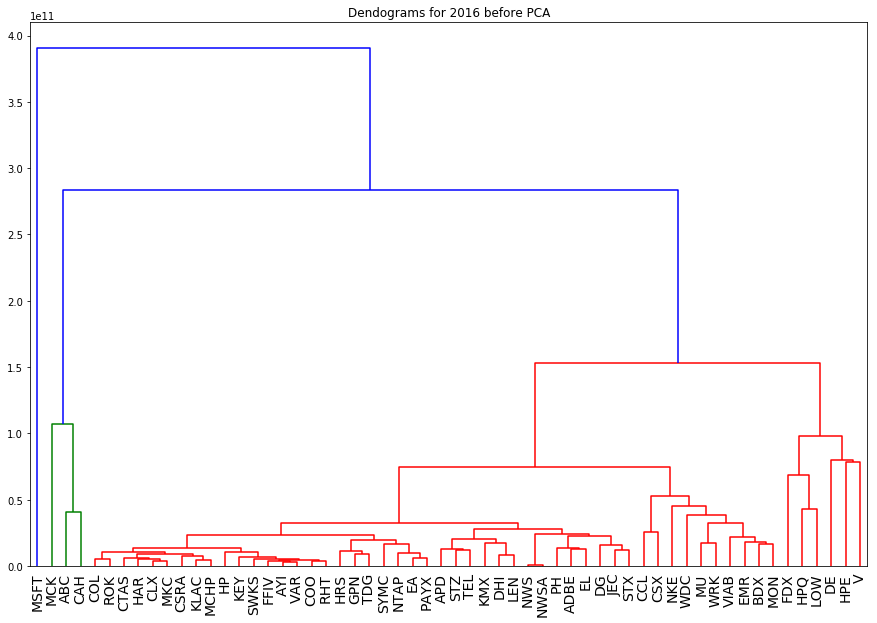

['ABC', 'ADBE', 'APD', 'AYI', 'BDX', 'CAH', 'CCL', 'CLX', 'COL', 'COO', 'CSRA', 'CSX', 'CTAS', 'DE', 'DG', 'DHI', 'EA', 'EL', 'EMR', 'FDX', 'FFIV', 'GPN', 'HAR', 'HP', 'HPE', 'HPQ', 'HRS', 'JEC', 'KEY', 'KLAC', 'KMX', 'LEN', 'LOW', 'MCHP', 'MCK', 'MKC', 'MON', 'MSFT', 'MU', 'NKE', 'NTAP', 'NWS', 'NWSA', 'PAYX', 'PH', 'RHT', 'ROK', 'STX', 'STZ', 'SWKS', 'SYMC', 'TDG', 'TEL', 'V', 'VAR', 'VIAB', 'WDC', 'WRK']


In [487]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp16 = data2016.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2016 before PCA")
mergings = linkage(hcbp16, method='complete')#ward)
labels=names2016
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2016,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [488]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp16) 

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

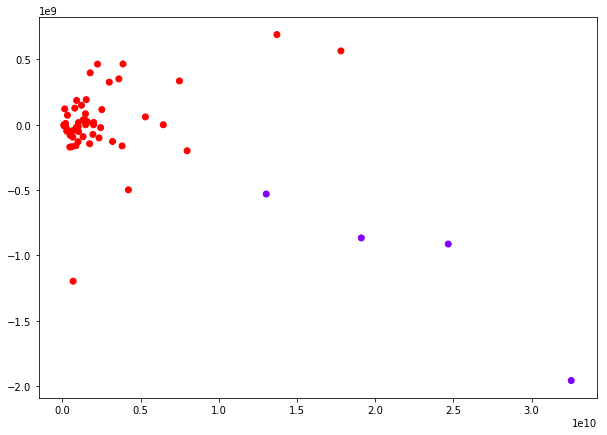

In [489]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp16[:,0], hcbp16[:,1], c=cluster.labels_, cmap='rainbow')  

## Hierarchical Clustering after PCA

### HC for 2012 after PCA

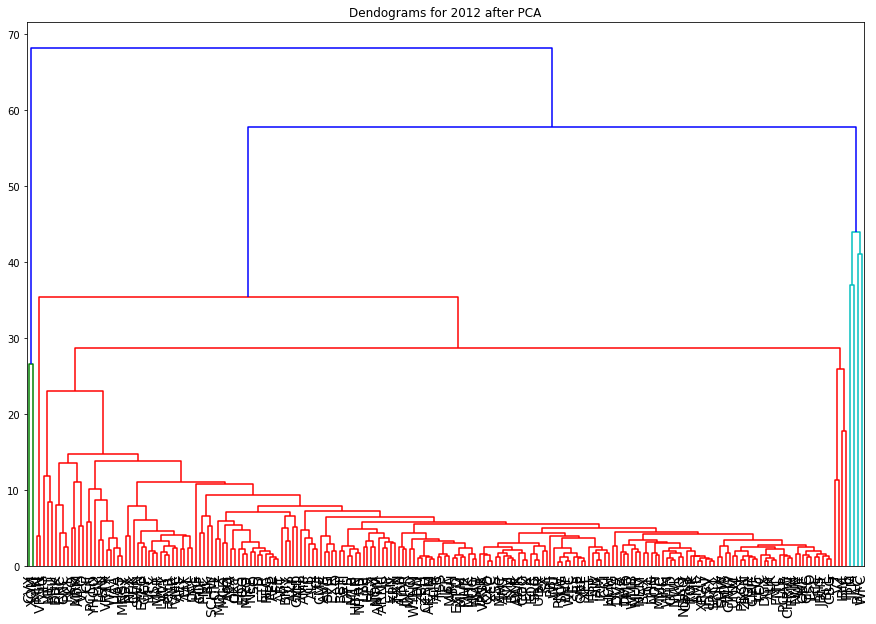

['AAL', 'ABT', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AKAM', 'ALB', 'ALK', 'ALL', 'AME', 'AMG', 'AMP', 'AMT', 'ANTM', 'AON', 'APA', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'BAC', 'BAX', 'BBT', 'BK', 'BLL', 'BMY', 'BSX', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CF', 'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CME', 'CNC', 'CNP', 'COF', 'COG', 'CTL', 'CTSH', 'CVX', 'CXO', 'D', 'DFS', 'DGX', 'DHR', 'DLR', 'DNB', 'DUK', 'DVA', 'ECL', 'EFX', 'EIX', 'EMN', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'FCX', 'FE', 'FIS', 'FISV', 'FLIR', 'FMC', 'FSLR', 'FTR', 'GGP', 'GILD', 'GPC', 'GWW', 'HAS', 'HBAN', 'HCN', 'HES', 'HIG', 'HOG', 'HST', 'HSY', 'IBM', 'IDXX', 'IFF', 'IP', 'IPG', 'IRM', 'IVZ', 'JBHT', 'JNPR', 'JPM', 'KIM', 'KO', 'LEG', 'LH', 'LKQ', 'LLL', 'LLY', 'LNT', 'LUK', 'LVLT', 'LYB', 'MAA', 'MAC', 'MAR', 'MAT', 'MCD', 'MCO', 'MDLZ', 'MET', 'MHK', 'MJN', 'MLM', 'MMC', 'MNST', 'MO', 'MRK', 'MRO', 'MTB', 'MUR', 'NDAQ', 'NEE', 'NEM', 'NFX', 'NOV',

In [490]:
hcap12 = pca2012.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2012 after PCA")
mergings = linkage(hcap12, method='complete')#ward)
labels=pcaname2012
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2012,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [491]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap12) 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

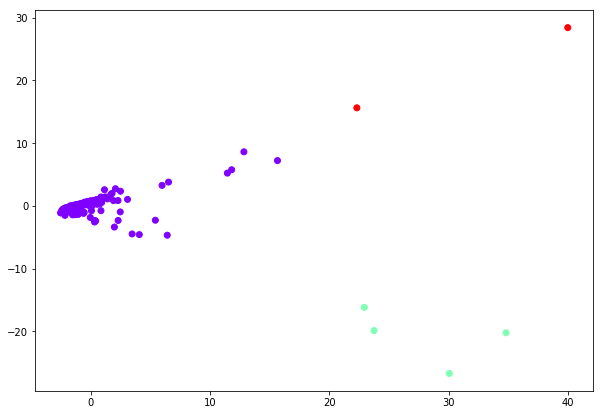

In [492]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap12[:,0], hcap12[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2013 after PCA

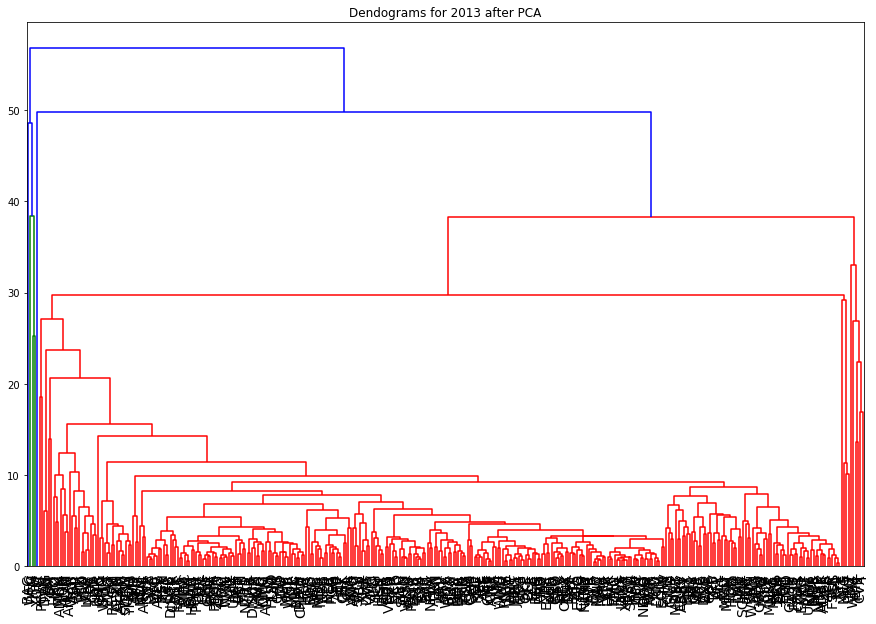

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC',

In [493]:
hcap13 = pca2013.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2013 after PCA")
mergings = linkage(hcap13, method='complete')#ward)
labels=pcaname2013
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2013,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [494]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap13) 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,

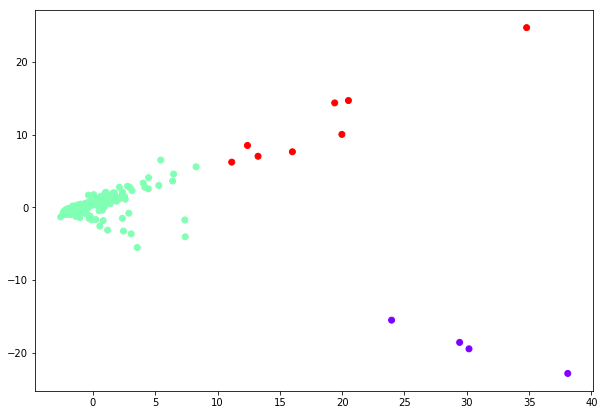

In [495]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap13[:,0], hcap13[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2014 after PCA

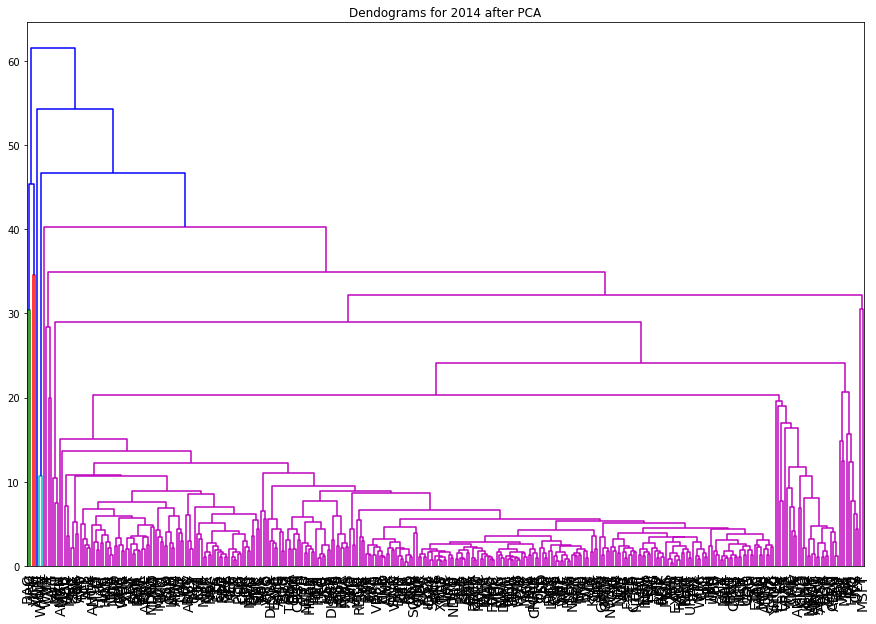

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'F

In [496]:
hcap14 = pca2014.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2014 after PCA")
mergings = linkage(hcap14, method='complete')#ward)
labels=pcaname2014
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2014,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [497]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap14) 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

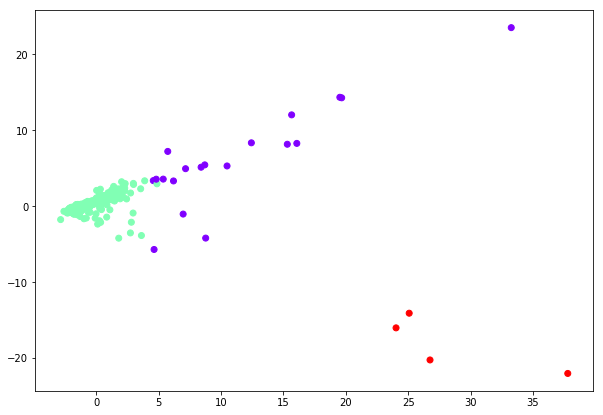

In [498]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap14[:,0], hcap14[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2015 after PCA

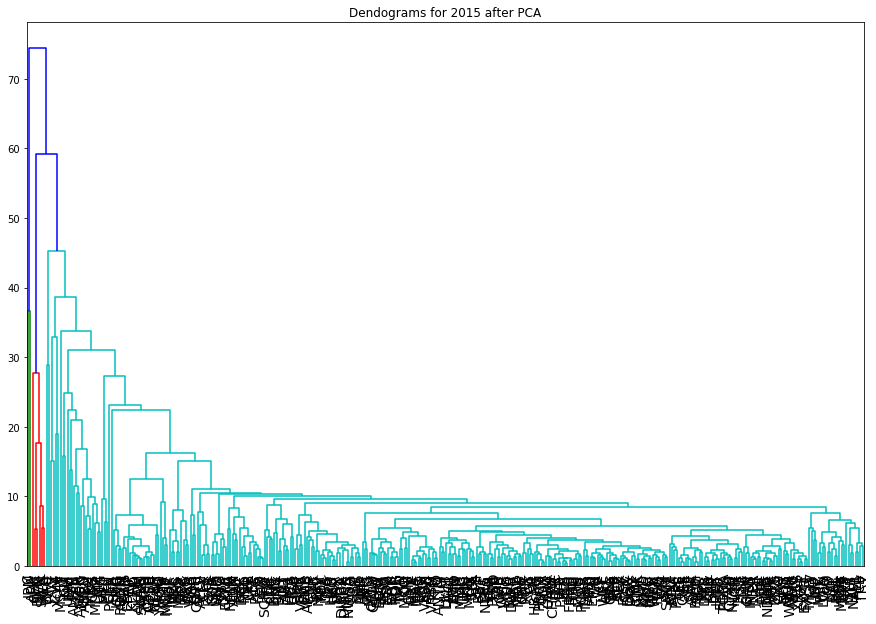

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CCL', 'CELG', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC', 'F

In [499]:
hcap15 = pca2015.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2015 after PCA")
mergings = linkage(hcap15, method='complete')#ward)
labels=pcaname2015
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2015,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [500]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap15) 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

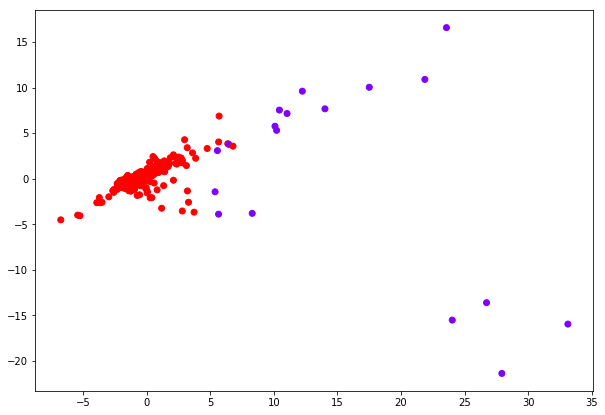

In [501]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap15[:,0], hcap15[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2016 after PCA

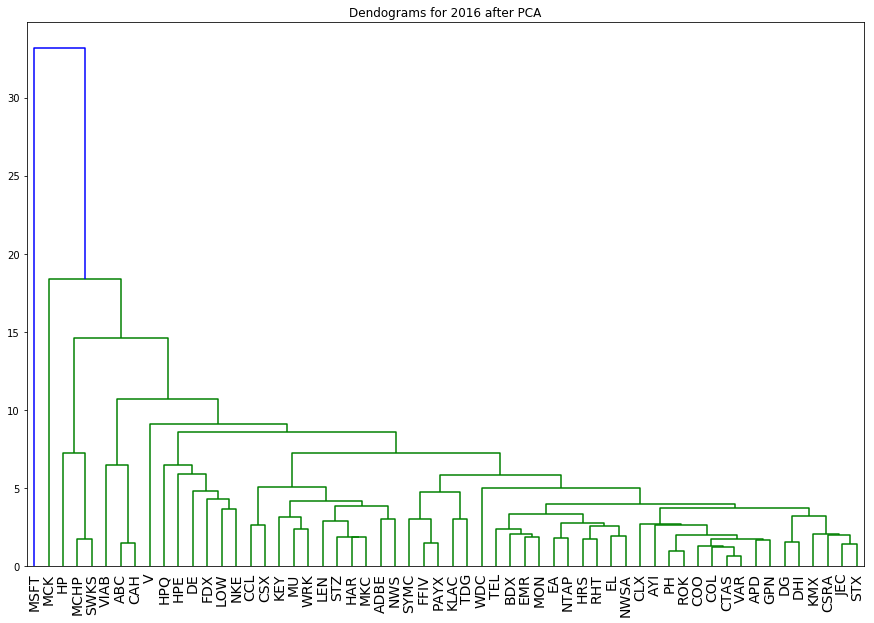

['ABC', 'ADBE', 'APD', 'AYI', 'BDX', 'CAH', 'CCL', 'CLX', 'COL', 'COO', 'CSRA', 'CSX', 'CTAS', 'DE', 'DG', 'DHI', 'EA', 'EL', 'EMR', 'FDX', 'FFIV', 'GPN', 'HAR', 'HP', 'HPE', 'HPQ', 'HRS', 'JEC', 'KEY', 'KLAC', 'KMX', 'LEN', 'LOW', 'MCHP', 'MCK', 'MKC', 'MON', 'MSFT', 'MU', 'NKE', 'NTAP', 'NWS', 'NWSA', 'PAYX', 'PH', 'RHT', 'ROK', 'STX', 'STZ', 'SWKS', 'SYMC', 'TDG', 'TEL', 'V', 'VAR', 'VIAB', 'WDC', 'WRK']


In [502]:
hcap16 = pca2016.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2016 after PCA")
mergings = linkage(hcap16, method='complete')#ward)
labels=pcaname2016
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2016,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [503]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap16) 

array([2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0])

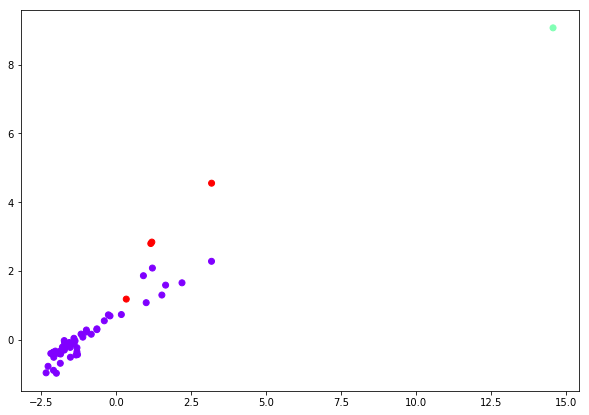

In [504]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap16[:,0], hcap16[:,1], c=cluster.labels_, cmap='rainbow')  

------------

# Profitability

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

## CLEANING

In [2]:
clean_data = pd.read_csv('final_merged_data.csv',index_col = 0)
clean_data.head()

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,trend
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.0
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.0
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.0
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.0
4,ABBV,2013-12-31,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,1.0


In [3]:
clean_data.columns

Index(['symbol', 'date', 'Accounts Payable', 'Accounts Receivable',
       'Add'l income/expense items', 'After Tax ROE', 'Capital Expenditures',
       'Capital Surplus', 'Cash Ratio', 'Cash and Cash Equivalents',
       'Changes in Inventories', 'Common Stocks', 'Cost of Revenue',
       'Current Ratio', 'Deferred Asset Charges', 'Deferred Liability Charges',
       'Depreciation', 'Earnings Before Interest and Tax',
       'Earnings Before Tax', 'Effect of Exchange Rate', 'Fixed Assets',
       'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax',
       'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments',
       'Liabilities', 'Long-Term Debt', 'Long-Term Investments',
       'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow',
       'Net Cash Flow-Operating', 'Net Cash Flows-Financing',
       'Net Cash Flows-Investing', 'Net Income', 'Net Income Adjustments',
       'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Op

In [4]:
#import category_encoders as ce
#ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
#clean_data = ohe.fit_transform(clean_data)

In [5]:
clean_data.drop(['symbol'], axis=1,inplace=True)
clean_data.drop(['date'], axis=1,inplace=True)
#drop PE and columns directly related to profitability
clean_data.drop(['PE'], axis=1,inplace=True)
clean_data.drop(['Earnings Per Share'], axis=1,inplace=True)

In [6]:
clean_data.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,For Year,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,2012,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,2013,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,2014,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,2015,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,2013,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,1.0


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(clean_data.loc[:, clean_data.columns != 'trend'], clean_data['trend'], test_size=0.30, random_state=42)

## Logistic Regression

In [8]:
#lbfgs would not converge
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
log_model = logreg.fit(X_train, Y_train)

log_Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
test_acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_log)
print("Accuracy score (test):",test_acc_log)

Accuracy score (training): 94.94
Accuracy score (test): 90.93


In [9]:
from sklearn.metrics import f1_score, roc_auc_score

model=logreg

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, log_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, log_Y_pred))

from sklearn import metrics

log_f1 = f1_score(Y_test,log_Y_pred)

print('F1:',log_f1)

ROC Train Accuracy: 0.83 | ROC Train Error: 0.17
ROC Test Accuracy: 0.76 | ROC Test Error: 0.24
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.56        42
         1.0       0.95      0.95      0.95       366

   micro avg       0.91      0.91      0.91       408
   macro avg       0.75      0.76      0.76       408
weighted avg       0.91      0.91      0.91       408

F1: 0.9493844049247606


## K-Nearest Neighbors

In [10]:
knn = KNeighborsClassifier() 
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_neighbors': [2, 5, 10, 50, 100],
    'p' : [1, 2],
    'leaf_size' :[30,50]
}

knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 10, n_jobs=-1)
knn_CV.fit(X_train, Y_train)

print(knn_CV.best_params_)
print(knn_CV.best_score_)

{'leaf_size': 30, 'n_neighbors': 5, 'p': 1}
0.8914646996838778


In [12]:
knn = KNeighborsClassifier(leaf_size=30, n_neighbors=5, p=1) 
knn_model = knn.fit(X_train, Y_train)  
knn_Y_pred = knn.predict(X_test)  

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
test_acc_knn = round(knn.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_knn)
print("Accuracy score (test):",test_acc_knn)

Accuracy score (training): 92.1
Accuracy score (test): 90.93


In [13]:
from sklearn.metrics import f1_score, roc_auc_score

model=knn

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, knn_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, knn_Y_pred))

from sklearn import metrics

knn_f1 = f1_score(Y_test,knn_Y_pred)

print('F1:',knn_f1)

ROC Train Accuracy: 0.70 | ROC Train Error: 0.30
ROC Test Accuracy: 0.60 | ROC Test Error: 0.40
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.69      0.21      0.33        42
         1.0       0.92      0.99      0.95       366

   micro avg       0.91      0.91      0.91       408
   macro avg       0.80      0.60      0.64       408
weighted avg       0.89      0.91      0.89       408

F1: 0.9513797634691196


## Gaussian Naive Bayes

In [14]:
gaussian = GaussianNB()
gaussian_model = gaussian.fit(X_train, Y_train) 

gaussian_Y_pred = gaussian.predict(X_test)  

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
test_acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_gaussian)
print("Accuracy score (test):",test_acc_gaussian)

Accuracy score (training): 30.24
Accuracy score (test): 23.77


In [15]:
from sklearn.metrics import f1_score, roc_auc_score

model=gaussian

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, gaussian_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, gaussian_Y_pred))

gaussian_f1 = f1_score(Y_test,gaussian_Y_pred)

from sklearn import metrics
print('F1:',gaussian_f1)

ROC Train Accuracy: 0.57 | ROC Train Error: 0.43
ROC Test Accuracy: 0.55 | ROC Test Error: 0.45
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.11      0.95      0.20        42
         1.0       0.97      0.16      0.27       366

   micro avg       0.24      0.24      0.24       408
   macro avg       0.54      0.55      0.24       408
weighted avg       0.88      0.24      0.26       408

F1: 0.26823529411764707


## Support Vector Classifier (SVC)

In [16]:
svc = SVC(kernel='rbf', gamma='auto')
svc_model = svc.fit(X_train, Y_train)

svc_Y_pred = svc.predict(X_test)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
test_acc_svc = round(svc.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_svc)
print("Accuracy score (test):",test_acc_svc)

Accuracy score (training): 100.0
Accuracy score (test): 89.71


In [17]:
from sklearn.metrics import f1_score, roc_auc_score

model=svc

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, svc_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, svc_Y_pred))

svc_f1 = f1_score(Y_test,svc_Y_pred)

from sklearn import metrics
print('F1:',svc_f1)

ROC Train Accuracy: 1.00 | ROC Train Error: 0.00
ROC Test Accuracy: 0.50 | ROC Test Error: 0.50
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        42
         1.0       0.90      1.00      0.95       366

   micro avg       0.90      0.90      0.90       408
   macro avg       0.45      0.50      0.47       408
weighted avg       0.80      0.90      0.85       408

F1: 0.9457364341085273


C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Decision Trees

In [18]:
decision_tree = DecisionTreeClassifier() 
decision_tree.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [19]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth' : depths,
    'min_samples_leaf' :[1, 5, 10, 20, 50, 100]
}

decision_tree_CV = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv= 10, n_jobs=-1)
decision_tree_CV.fit(X_train, Y_train)

print(decision_tree_CV.best_params_)
print(decision_tree_CV.best_score_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
1.0


In [20]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1) 
decision_tree_model = decision_tree.fit(X_train, Y_train)  
decision_tree_Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
test_acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_decision_tree)
print("Accuracy score (test):",test_acc_decision_tree)

Accuracy score (training): 100.0
Accuracy score (test): 99.51


In [21]:
from sklearn.metrics import f1_score, roc_auc_score

model=decision_tree

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, decision_tree_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, decision_tree_Y_pred))

dt_f1 = f1_score(Y_test,decision_tree_Y_pred)

from sklearn import metrics
print('F1:',dt_f1)

ROC Train Accuracy: 1.00 | ROC Train Error: 0.00
ROC Test Accuracy: 0.99 | ROC Test Error: 0.01
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        42
         1.0       1.00      1.00      1.00       366

   micro avg       1.00      1.00      1.00       408
   macro avg       0.99      0.99      0.99       408
weighted avg       1.00      1.00      1.00       408

F1: 0.9972677595628415


## Ensemble Methods

### AdaBoost

In [22]:
decision_tree = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator=decision_tree, n_estimators=180, random_state=1)
ada_model = ada.fit(X_train, Y_train)

ada_Y_pred = ada.predict(X_test)

acc_ada = round(ada.score(X_train, Y_train) * 100, 2)
test_acc_ada = round(ada.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_ada)
print("Accuracy score (test):",test_acc_ada)

Accuracy score (training): 100.0
Accuracy score (test): 99.51


In [23]:
from sklearn.metrics import f1_score, roc_auc_score

model=ada

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, ada_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, ada_Y_pred))

ada_f1 = f1_score(Y_test,ada_Y_pred)

from sklearn import metrics
print('F1:',ada_f1)

ROC Train Accuracy: 1.00 | ROC Train Error: 0.00
ROC Test Accuracy: 0.99 | ROC Test Error: 0.01
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        42
         1.0       1.00      1.00      1.00       366

   micro avg       1.00      1.00      1.00       408
   macro avg       0.99      0.99      0.99       408
weighted avg       1.00      1.00      1.00       408

F1: 0.9972677595628415


### Gradient Tree Boosting

In [24]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gt_model = gb.fit(X_train, Y_train)
    
    acc_gb = round(gb.score(X_train, Y_train) * 100, 2)
    test_acc_gb = round(gb.score(X_test, Y_test) * 100, 2)
    
    gb_Y_pred = gb.predict(X_test)
    
print("Learning rate: ", learning_rate)
print("Accuracy score (training):",acc_gb)
print("Accuracy score (test):",test_acc_gb)

Learning rate:  1
Accuracy score (training): 100.0
Accuracy score (test): 97.79


In [25]:
from sklearn.metrics import f1_score, roc_auc_score

model=gb

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, gb_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, gb_Y_pred))

gb_f1 = f1_score(Y_test,gb_Y_pred)

from sklearn import metrics
print('F1:',gb_f1)

ROC Train Accuracy: 1.00 | ROC Train Error: 0.00
ROC Test Accuracy: 0.97 | ROC Test Error: 0.03
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90        42
         1.0       0.99      0.98      0.99       366

   micro avg       0.98      0.98      0.98       408
   macro avg       0.92      0.97      0.94       408
weighted avg       0.98      0.98      0.98       408

F1: 0.9876203576341127


### Random Forest

In [26]:
random_forest = RandomForestClassifier()
random_forest.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [27]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : depths,
    'criterion' :['gini', 'entropy']
}

rf_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_CV.fit(X_train, Y_train)

print(rf_CV.best_params_)
print(rf_CV.best_score_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}
0.9989462592202318


In [28]:
random_forest = RandomForestClassifier(criterion='gini', max_depth=7, max_features='auto', n_estimators=200)
random_forest_model = random_forest.fit(X_train, Y_train)

random_Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
test_acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_random_forest)
print("Accuracy score (test):",test_acc_random_forest)

Accuracy score (training): 100.0
Accuracy score (test): 99.26


In [29]:
from sklearn.metrics import f1_score, roc_auc_score

model=random_forest

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, random_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, random_Y_pred))

rf_f1 = f1_score(Y_test,random_Y_pred)

from sklearn import metrics
print('F1:',rf_f1)

ROC Train Accuracy: 1.00 | ROC Train Error: 0.00
ROC Test Accuracy: 1.00 | ROC Test Error: 0.00
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        42
         1.0       1.00      0.99      1.00       366

   micro avg       0.99      0.99      0.99       408
   macro avg       0.97      1.00      0.98       408
weighted avg       0.99      0.99      0.99       408

F1: 0.9958847736625513


In [30]:
# Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Estimated Shares Outstanding,0.270
Net Income,0.102
Net Income Applicable to Common Shareholders,0.100
Earnings Before Tax,0.071
Earnings Before Interest and Tax,0.064
Net Income-Cont. Operations,0.061
Operating Income,0.029
Income Tax,0.017
Non-Recurring Items,0.013


## Stochastic Gradient Descent (SGD)

In [31]:
sgd = linear_model.SGDClassifier()
sgd.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2'],
}

sgd_CV = GridSearchCV(estimator=sgd, param_grid=param_grid, cv= 5, n_jobs=-1)
sgd_CV.fit(X_train, Y_train)

print(sgd_CV.best_params_)
print(sgd_CV.best_score_)

{'loss': 'hinge', 'penalty': 'l1'}
0.863013698630137


C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [34]:
sgd = linear_model.SGDClassifier(loss='hinge', penalty='l1',max_iter=1000)
sgd_model = sgd.fit(X_train, Y_train)
sgd_Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
test_acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_sgd)
print("Accuracy score (test):",test_acc_sgd)

Accuracy score (training): 89.04
Accuracy score (test): 88.24


In [35]:
from sklearn.metrics import f1_score, roc_auc_score

model=sgd

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, sgd_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, sgd_Y_pred))

sgd_f1 = f1_score(Y_test,sgd_Y_pred)

from sklearn import metrics
print('F1:',sgd_f1)

ROC Train Accuracy: 0.74 | ROC Train Error: 0.26
ROC Test Accuracy: 0.68 | ROC Test Error: 0.32
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.43      0.43      0.43        42
         1.0       0.93      0.93      0.93       366

   micro avg       0.88      0.88      0.88       408
   macro avg       0.68      0.68      0.68       408
weighted avg       0.88      0.88      0.88       408

F1: 0.9344262295081968


## Perceptron

In [36]:
perceptron = Perceptron(max_iter=5)
perceptron_model = perceptron.fit(X_train, Y_train)

perceptron_Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
test_acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_perceptron)
print("Accuracy score (test):",test_acc_perceptron)

Accuracy score (training): 88.2
Accuracy score (test): 89.71


In [37]:
from sklearn.metrics import f1_score, roc_auc_score

model=perceptron

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, perceptron_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, perceptron_Y_pred))

perceptron_f1 = f1_score(Y_test,perceptron_Y_pred)

from sklearn import metrics
print('F1:',perceptron_f1)

ROC Train Accuracy: 0.53 | ROC Train Error: 0.47
ROC Test Accuracy: 0.52 | ROC Test Error: 0.48
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

         0.0       0.50      0.05      0.09        42
         1.0       0.90      0.99      0.95       366

   micro avg       0.90      0.90      0.90       408
   macro avg       0.70      0.52      0.52       408
weighted avg       0.86      0.90      0.86       408

F1: 0.9454545454545454


## COMPARE

In [38]:
results = pd.DataFrame({
    'Model': ['Logistic Regression','K-Nearest Neighbors',
             'Gaussian Naive Bayes','Support Vector Classifier (SVC)',
             'Decision Trees','AdaBoost','Gradient Tree Boosting',
             'Random Forest','Stochastic Gradient Descent (SGD)','Perceptron'],
    'Score': [test_acc_log,
              test_acc_knn,
              test_acc_gaussian,
              test_acc_svc,
              test_acc_decision_tree,
              test_acc_ada,
              test_acc_gb,
              test_acc_random_forest,
              test_acc_sgd,
              test_acc_perceptron],
    'F1': [round(log_f1, 2),
                round(knn_f1, 2),
                round(gaussian_f1, 2),
                round(svc_f1, 2),
                round(dt_f1, 2),
                round(ada_f1, 2),
                round(gb_f1, 2),
                round(rf_f1, 2),
                round(sgd_f1, 2),
                round(perceptron_f1, 2)
                ]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model,F1
Score,,
99.51,Decision Trees,1.00
99.51,AdaBoost,1.00
99.26,Random Forest,1.00
97.79,Gradient Tree Boosting,0.99
90.93,Logistic Regression,0.95
90.93,K-Nearest Neighbors,0.95
89.71,Support Vector Classifier (SVC),0.95
89.71,Perceptron,0.95
88.24,Stochastic Gradient Descent (SGD),0.93


# PCA

In [39]:
clean_data2=clean_data.copy()
#temp dropping trend
clean_data2.drop(['trend'], axis=1,inplace=True)

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def fit_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)   
    return pca

In [41]:
def standardize(df):
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)    
    return scaled

In [42]:
scaled = standardize(clean_data2)

C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
pca = fit_pca(scaled, n_components=25)

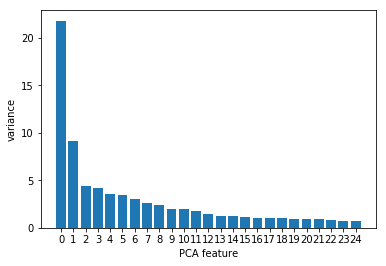

In [44]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

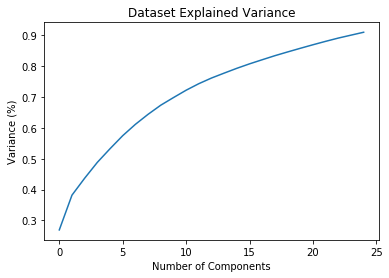

In [45]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [46]:
vars = pca.explained_variance_ratio_
c_names = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10',
           'f11','f12','f13','f14','f15','f16','f17','f18','f19','f20',
           'f21','f22','f23','f24','f25','f26','f27','f28','f29','f30',
           'f31','f32','f33','f34','f35','f36','f37','f38','f39','f40',
           'f41','f42','f43','f44','f45','f46','f47','f48','f49','f50',
           'f51','f52','f53','f54','f55','f56','f57','f58','f59','f60',
           'f61','f62','f63','f64','f65','f66','f67','f68','f69','f70',
           'f71','f72','f73','f74','f75','f76','f77','f78','f79','f80',
           'f81','f82']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
26.9%:     0.18 * f1 +  0.02 * f2 +  0.06 * f3 + -0.01 * f4 + -0.12 * f5 +  0.13 * f6 + -0.01 * f7 +  0.15 * f8 + -0.03 * f9 +  0.10 * f10 +  0.11 * f11 + -0.02 * f12 +  0.04 * f13 +  0.11 * f14 +  0.14 * f15 +  0.20 * f16 +  0.18 * f17 + -0.09 * f18 +  0.12 * f19 +  0.14 * f20 + -0.01 * f21 +  0.17 * f22 +  0.17 * f23 +  0.08 * f24 +  0.15 * f25 +  0.07 * f26 + -0.09 * f27 +  0.00 * f28 +  0.15 * f29 +  0.15 * f30 +  0.10 * f31 +  0.01 * f32 + -0.03 * f33 + -0.01 * f34 +  0.18 * f35 +  0.00 * f36 + -0.12 * f37 +  0.18 * f38 + -0.02 * f39 +  0.18 * f40 +  0.18 * f41 +  0.15 * f42 +  0.05 * f43 +  0.16 * f44 + -0.02 * f45 +  0.09 * f46 +  0.08 * f47 +  0.14 * f48 + -0.07 * f49 +  0.09 * f50 + -0.01 * f51 +  0.04 * f52 +  0.05 * f53 +  0.11 * f54 + -0.01 * f55 + -0.01 * f56 + -0.01 * f57 + -0.01 * f58 +  0.05 * f59 +  0.17 * f60 + -0.09 * f61 +  0.19 * f62 +  0.15 * f63 +  0.06 * f64 +  0.17 * f65 +  0.10 * f66 +  0.12 * f67 +

In [47]:
pca = PCA(n_components=20)
reduced = pca.fit_transform(scaled)

In [48]:
reduced_df = pd.DataFrame.from_records(reduced)
reduced_df.insert(0, column='trend', value=clean_data.trend)
reduced_df['trend']=reduced_df['trend'].astype(np.int)
reduced_df.head()

,trend,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,-1.457071,-0.523728,-2.156216,-0.045154,-0.771425,0.655774,0.435635,-1.287651,0.709629,...,0.043738,0.058232,-0.142471,-0.552857,-0.047765,-0.955456,0.769690,0.263870,-1.241286,1.097445
1,0,-0.827453,-0.276551,-1.713066,0.047274,-0.450880,1.385299,0.706473,-1.452406,1.192144,...,0.515025,-0.174743,-0.766355,-1.187277,-0.585611,-1.267406,0.484515,0.443640,-0.580105,0.786000
2,1,1.492694,1.122087,-0.909513,0.232302,-0.346639,0.085384,-0.196430,-0.913378,0.359606,...,0.815817,0.108854,0.296950,-0.859227,-0.025868,-0.795227,0.278938,0.539054,-0.520791,-0.234904
3,1,2.321122,1.461731,-0.899096,0.089489,-0.041099,0.010702,-0.167971,-0.270415,0.134538,...,1.341069,-1.013491,0.150453,-1.014577,0.378935,-0.035479,-0.139811,0.141502,0.203001,-0.170075
4,1,0.679561,0.685771,0.538065,1.340784,0.640833,1.700319,-1.685896,1.122334,0.098372,...,0.672627,-0.647640,0.079995,1.259658,-1.086763,-1.020304,-0.737110,0.009530,-0.296795,0.750157


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(reduced_df.iloc[:,1:], reduced_df['trend'], test_size=0.30, random_state=42)

## Logistic Regression

In [50]:
#lbfgs would not converge
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
log_model = logreg.fit(X_train, Y_train)

log_Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
test_acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_log)
print("Accuracy score (test):",test_acc_log)

Accuracy score (training): 89.99
Accuracy score (test): 91.18


In [51]:
from sklearn.metrics import f1_score, roc_auc_score

model=logreg

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, log_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, log_Y_pred))

from sklearn import metrics

log_f1 = f1_score(Y_test,log_Y_pred)

print('F1:',log_f1)

ROC Train Accuracy: 0.60 | ROC Train Error: 0.40
ROC Test Accuracy: 0.59 | ROC Test Error: 0.41
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.80      0.19      0.31        42
           1       0.91      0.99      0.95       366

   micro avg       0.91      0.91      0.91       408
   macro avg       0.86      0.59      0.63       408
weighted avg       0.90      0.91      0.89       408

F1: 0.9528795811518324


## K-Nearest Neighbors

In [52]:
knn = KNeighborsClassifier() 
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_neighbors': [2, 5, 10, 50, 100],
    'p' : [1, 2],
    'leaf_size' :[30,50]
}

knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 10, n_jobs=-1)
knn_CV.fit(X_train, Y_train)

print(knn_CV.best_params_)
print(knn_CV.best_score_)

{'leaf_size': 30, 'n_neighbors': 10, 'p': 1}
0.8956796628029505


In [54]:
knn = KNeighborsClassifier(leaf_size=30, n_neighbors=10, p=1) 
knn_model = knn.fit(X_train, Y_train)  
knn_Y_pred = knn.predict(X_test)  

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
test_acc_knn = round(knn.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_knn)
print("Accuracy score (test):",test_acc_knn)

Accuracy score (training): 90.31
Accuracy score (test): 89.95


In [55]:
from sklearn.metrics import f1_score, roc_auc_score

model=knn

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, knn_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, knn_Y_pred))

from sklearn import metrics

knn_f1 = f1_score(Y_test,knn_Y_pred)

print('F1:',knn_f1)

ROC Train Accuracy: 0.62 | ROC Train Error: 0.38
ROC Test Accuracy: 0.58 | ROC Test Error: 0.42
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.54      0.17      0.25        42
           1       0.91      0.98      0.95       366

   micro avg       0.90      0.90      0.90       408
   macro avg       0.72      0.58      0.60       408
weighted avg       0.87      0.90      0.87       408

F1: 0.9461235216819973


## Gaussian Naive Bayes

In [56]:
gaussian = GaussianNB()
gaussian_model = gaussian.fit(X_train, Y_train) 

gaussian_Y_pred = gaussian.predict(X_test)  

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
test_acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_gaussian)
print("Accuracy score (test):",test_acc_gaussian)

Accuracy score (training): 43.1
Accuracy score (test): 32.6


In [57]:
from sklearn.metrics import f1_score, roc_auc_score

model=gaussian

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, gaussian_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, gaussian_Y_pred))

gaussian_f1 = f1_score(Y_test,gaussian_Y_pred)

from sklearn import metrics
print('F1:',gaussian_f1)

ROC Train Accuracy: 0.59 | ROC Train Error: 0.41
ROC Test Accuracy: 0.54 | ROC Test Error: 0.46
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.11      0.81      0.20        42
           1       0.93      0.27      0.42       366

   micro avg       0.33      0.33      0.33       408
   macro avg       0.52      0.54      0.31       408
weighted avg       0.84      0.33      0.40       408

F1: 0.4186046511627908


## Support Vector Classifier (SVC)

In [58]:
svc = SVC(kernel='rbf', gamma='auto')
svc_model = svc.fit(X_train, Y_train)

svc_Y_pred = svc.predict(X_test)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
test_acc_svc = round(svc.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_svc)
print("Accuracy score (test):",test_acc_svc)

Accuracy score (training): 91.04
Accuracy score (test): 89.95


In [59]:
from sklearn.metrics import f1_score, roc_auc_score

model=svc

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, svc_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, svc_Y_pred))

svc_f1 = f1_score(Y_test,svc_Y_pred)

from sklearn import metrics
print('F1:',svc_f1)

ROC Train Accuracy: 0.64 | ROC Train Error: 0.36
ROC Test Accuracy: 0.52 | ROC Test Error: 0.48
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.67      0.05      0.09        42
           1       0.90      1.00      0.95       366

   micro avg       0.90      0.90      0.90       408
   macro avg       0.78      0.52      0.52       408
weighted avg       0.88      0.90      0.86       408

F1: 0.9468223086900129


## Decision Trees

In [60]:
decision_tree = DecisionTreeClassifier() 
decision_tree.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [61]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth' : depths,
    'min_samples_leaf' :[1, 5, 10, 20, 50, 100]
}

decision_tree_CV = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv= 10, n_jobs=-1)
decision_tree_CV.fit(X_train, Y_train)

print(decision_tree_CV.best_params_)
print(decision_tree_CV.best_score_)

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 20}
0.880927291886196


C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [62]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=20) 
decision_tree_model = decision_tree.fit(X_train, Y_train)  
decision_tree_Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
test_acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_decision_tree)
print("Accuracy score (test):",test_acc_decision_tree)

Accuracy score (training): 89.15
Accuracy score (test): 89.71


In [63]:
from sklearn.metrics import f1_score, roc_auc_score

model=decision_tree

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, decision_tree_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, decision_tree_Y_pred))

dt_f1 = f1_score(Y_test,decision_tree_Y_pred)

from sklearn import metrics
print('F1:',dt_f1)

ROC Train Accuracy: 0.57 | ROC Train Error: 0.43
ROC Test Accuracy: 0.54 | ROC Test Error: 0.46
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        42
           1       0.91      0.99      0.95       366

   micro avg       0.90      0.90      0.90       408
   macro avg       0.70      0.54      0.55       408
weighted avg       0.86      0.90      0.86       408

F1: 0.9451697127937337


## Ensemble Methods

### AdaBoost

In [64]:
decision_tree = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator=decision_tree, n_estimators=180, random_state=1)
ada_model = ada.fit(X_train, Y_train)

ada_Y_pred = ada.predict(X_test)

acc_ada = round(ada.score(X_train, Y_train) * 100, 2)
test_acc_ada = round(ada.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_ada)
print("Accuracy score (test):",test_acc_ada)

Accuracy score (training): 100.0
Accuracy score (test): 83.58


In [65]:
from sklearn.metrics import f1_score, roc_auc_score

model=ada

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, ada_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, ada_Y_pred))

ada_f1 = f1_score(Y_test,ada_Y_pred)

from sklearn import metrics
print('F1:',ada_f1)

ROC Train Accuracy: 1.00 | ROC Train Error: 0.00
ROC Test Accuracy: 0.59 | ROC Test Error: 0.41
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.24      0.29      0.26        42
           1       0.92      0.90      0.91       366

   micro avg       0.84      0.84      0.84       408
   macro avg       0.58      0.59      0.59       408
weighted avg       0.85      0.84      0.84       408

F1: 0.9075862068965518


### Gradient Tree Boosting

In [66]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gt_model = gb.fit(X_train, Y_train)
    
    acc_gb = round(gb.score(X_train, Y_train) * 100, 2)
    test_acc_gb = round(gb.score(X_test, Y_test) * 100, 2)
    
    gb_Y_pred = gb.predict(X_test)
    
print("Learning rate: ", learning_rate)
print("Accuracy score (training):",acc_gb)
print("Accuracy score (test):",test_acc_gb)

Learning rate:  1
Accuracy score (training): 94.94
Accuracy score (test): 87.99


In [67]:
from sklearn.metrics import f1_score, roc_auc_score

model=gb

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, gb_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, gb_Y_pred))

gb_f1 = f1_score(Y_test,gb_Y_pred)

from sklearn import metrics
print('F1:',gb_f1)

ROC Train Accuracy: 0.82 | ROC Train Error: 0.18
ROC Test Accuracy: 0.61 | ROC Test Error: 0.39
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.38      0.26      0.31        42
           1       0.92      0.95      0.93       366

   micro avg       0.88      0.88      0.88       408
   macro avg       0.65      0.61      0.62       408
weighted avg       0.86      0.88      0.87       408

F1: 0.934228187919463


### Random Forest

In [68]:
random_forest = RandomForestClassifier()
random_forest.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [69]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : depths,
    'criterion' :['gini', 'entropy']
}

rf_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_CV.fit(X_train, Y_train)

print(rf_CV.best_params_)
print(rf_CV.best_score_)

{'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 100}
0.9020021074815595


In [70]:
random_forest = RandomForestClassifier(criterion='gini', max_depth=12, max_features='sqrt', n_estimators=100)
random_forest_model = random_forest.fit(X_train, Y_train)

random_Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
test_acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_random_forest)
print("Accuracy score (test):",test_acc_random_forest)

Accuracy score (training): 99.79
Accuracy score (test): 90.44


In [71]:
from sklearn.metrics import f1_score, roc_auc_score

model=random_forest

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, random_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, random_Y_pred))

rf_f1 = f1_score(Y_test,random_Y_pred)

from sklearn import metrics
print('F1:',rf_f1)

ROC Train Accuracy: 0.99 | ROC Train Error: 0.01
ROC Test Accuracy: 0.57 | ROC Test Error: 0.43
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.67      0.14      0.24        42
           1       0.91      0.99      0.95       366

   micro avg       0.90      0.90      0.90       408
   macro avg       0.79      0.57      0.59       408
weighted avg       0.88      0.90      0.88       408

F1: 0.9490196078431372


In [72]:
# Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
0,0.087
1,0.075
17,0.074
2,0.070
10,0.068
13,0.056
4,0.055
9,0.051
8,0.044


## Stochastic Gradient Descent (SGD)

In [73]:
sgd = linear_model.SGDClassifier()
sgd.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2'],
}

sgd_CV = GridSearchCV(estimator=sgd, param_grid=param_grid, cv= 5, n_jobs=-1)
sgd_CV.fit(X_train, Y_train)

print(sgd_CV.best_params_)
print(sgd_CV.best_score_)

{'loss': 'log', 'penalty': 'l2'}
0.8977871443624869


C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [75]:
sgd = linear_model.SGDClassifier(loss='log', penalty='l2',max_iter=1000)
sgd_model = sgd.fit(X_train, Y_train)
sgd_Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
test_acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_sgd)
print("Accuracy score (test):",test_acc_sgd)

Accuracy score (training): 90.41
Accuracy score (test): 91.42


In [76]:
from sklearn.metrics import f1_score, roc_auc_score

model=sgd

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, sgd_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, sgd_Y_pred))

sgd_f1 = f1_score(Y_test,sgd_Y_pred)

from sklearn import metrics
print('F1:',sgd_f1)

ROC Train Accuracy: 0.61 | ROC Train Error: 0.39
ROC Test Accuracy: 0.59 | ROC Test Error: 0.41
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.89      0.19      0.31        42
           1       0.91      1.00      0.95       366

   micro avg       0.91      0.91      0.91       408
   macro avg       0.90      0.59      0.63       408
weighted avg       0.91      0.91      0.89       408

F1: 0.954248366013072


## Perceptron

In [77]:
perceptron = Perceptron(max_iter=5)
perceptron_model = perceptron.fit(X_train, Y_train)

perceptron_Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
test_acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_perceptron)
print("Accuracy score (test):",test_acc_perceptron)

Accuracy score (training): 87.67
Accuracy score (test): 87.99


In [78]:
from sklearn.metrics import f1_score, roc_auc_score

model=perceptron

train_predictions = model.predict(X_train)

train_accuracy = roc_auc_score(Y_train, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, perceptron_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, perceptron_Y_pred))

perceptron_f1 = f1_score(Y_test,perceptron_Y_pred)

from sklearn import metrics
print('F1:',perceptron_f1)

ROC Train Accuracy: 0.61 | ROC Train Error: 0.39
ROC Test Accuracy: 0.56 | ROC Test Error: 0.44
OVERFIT: True
UNDERFIT: False
              precision    recall  f1-score   support

           0       0.33      0.17      0.22        42
           1       0.91      0.96      0.93       366

   micro avg       0.88      0.88      0.88       408
   macro avg       0.62      0.56      0.58       408
weighted avg       0.85      0.88      0.86       408

F1: 0.9349269588313414


## COMPARE

In [79]:
results = pd.DataFrame({
    'Model': ['Logistic Regression','K-Nearest Neighbors',
             'Gaussian Naive Bayes','Support Vector Classifier (SVC)',
             'Decision Trees','AdaBoost','Gradient Tree Boosting',
             'Random Forest','Stochastic Gradient Descent (SGD)','Perceptron'],
    'Score': [test_acc_log,
              test_acc_knn,
              test_acc_gaussian,
              test_acc_svc,
              test_acc_decision_tree,
              test_acc_ada,
              test_acc_gb,
              test_acc_random_forest,
              test_acc_sgd,
              test_acc_perceptron],
    'F1': [round(log_f1, 2),
                round(knn_f1, 2),
                round(gaussian_f1, 2),
                round(svc_f1, 2),
                round(dt_f1, 2),
                round(ada_f1, 2),
                round(gb_f1, 2),
                round(rf_f1, 2),
                round(sgd_f1, 2),
                round(perceptron_f1, 2)
                ]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model,F1
Score,,
91.42,Stochastic Gradient Descent (SGD),0.95
91.18,Logistic Regression,0.95
90.44,Random Forest,0.95
89.95,K-Nearest Neighbors,0.95
89.95,Support Vector Classifier (SVC),0.95
89.71,Decision Trees,0.95
87.99,Gradient Tree Boosting,0.93
87.99,Perceptron,0.93
83.58,AdaBoost,0.91


# Attempt to improve Random Forest w/ SMOTE

In [124]:
clean_data3=clean_data.copy()
clean_data3.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,For Year,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,2012,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,2013,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,2014,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,2015,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,2013,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,1.0


In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(clean_data3.loc[:, clean_data3.columns != 'trend'], clean_data3['trend'], test_size=0.30, random_state=42)

In [131]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=45, ratio = .4)
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [132]:
random_forest = RandomForestClassifier()
random_forest.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [133]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'n_estimators': [100, 200],
    'max_depth' : depths,
    'criterion' :['gini', 'entropy']
}

rf_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_CV.fit(x_train_res, y_train_res)

print(rf_CV.best_params_)
print(rf_CV.best_score_)

{'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 100}
0.9853951890034365


In [134]:
random_forest = RandomForestClassifier(criterion='entropy', max_depth=18, max_features='auto', n_estimators=100)
random_forest_model = random_forest.fit(X_train, Y_train)

random_Y_pred = random_forest.predict(X_test)

random_forest.score(x_train_res, y_train_res)
acc_random_forest = round(random_forest.score(x_train_res, y_train_res) * 100, 2)
test_acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_random_forest)
print("Accuracy score (test):",test_acc_random_forest)

Accuracy score (training): 97.51
Accuracy score (test): 99.26


In [135]:
from sklearn.metrics import f1_score, roc_auc_score

model=random_forest

train_predictions = model.predict(x_train_res)

train_accuracy = roc_auc_score(y_train_res, train_predictions)
train_error_rate = 1 - train_accuracy
test_accuracy = roc_auc_score(Y_test, random_Y_pred)
test_error_rate = 1 - test_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

from sklearn.metrics import classification_report
print(classification_report(Y_test, random_Y_pred))

rf_f1 = f1_score(Y_test,random_Y_pred)

from sklearn import metrics
print('F1:',rf_f1)

ROC Train Accuracy: 0.96 | ROC Train Error: 0.04
ROC Test Accuracy: 0.99 | ROC Test Error: 0.01
OVERFIT: False
UNDERFIT: True
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96        42
         1.0       1.00      0.99      1.00       366

   micro avg       0.99      0.99      0.99       408
   macro avg       0.98      0.99      0.98       408
weighted avg       0.99      0.99      0.99       408

F1: 0.9958960328317372


In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

# cross-validation
# cv = KFold(n_splits=3, shuffle=True) # shuffle and divide in 3 equal parts
cv = StratifiedKFold(n_splits=10, shuffle=True) # KFold with 'stratify' option
# # test_size is available in ShuffleSplit
# cv = ShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(model, X_test, Y_test, cv=cv)
print("Mean score:", np.mean(scores))

Mean score: 0.9681620209059233


# Bankruptcy Prediction - Regression

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
import matplotlib as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
import sklearn.model_selection as cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE
from imblearn.over_sampling import SMOTE

In [2]:
data=pd.read_csv("final_merged_data.csv")
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.drop(['For Year'],axis=1,inplace=True)
data.head()

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,trend
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.0
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.0
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.0
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.0
4,ABBV,2013-12-31,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,1.0


#### calculating Altman's score:
Z-Score =  1.2(A) + 1.4(B) + 3.3(C) + 0.6(D) + 1.0(E)

Here is the link:https://www.investopedia.com/terms/a/altman.asp

In [4]:
first=1.2*((data['Total Current Assets']-data['Total Current Liabilities'])/data['Total Assets'])
second=1.4*((data['Retained Earnings'])/data['Total Assets'])
third=3.3*((data['Earnings Before Interest and Tax']/data['Total Assets']))
fourth=0.6*((data['Estimated Shares Outstanding']*data['close'])/data['Total Liabilities'])
fifth = 1*((data['Total Revenue'])/data['Total Assets'])
z_score=first+second+third+fourth+fifth
data['z_score']=z_score
data.drop(['trend'],axis=1,inplace=True)
data.head(10)

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,z_score
0,AAL,2012-12-31,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.249317
1,AAL,2013-12-31,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.224697
2,AAL,2014-12-31,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.536275
3,AAL,2015-12-31,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.492806
4,ABBV,2013-12-31,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,3.855570
5,ABBV,2014-12-31,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.0,8.348000e+09,...,1.598198e+09,66.720001,65.440002,65.349998,67.099998,3917300.0,4,87,58.954957,3.723185
6,ABBV,2015-12-31,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,...,1.633016e+09,59.500000,59.240002,59.200001,59.930000,6019300.0,4,87,18.806350,2.250887
7,ABC,2013-09-30,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.0,1.231006e+09,...,2.306952e+08,60.900002,61.099998,60.689999,61.270000,1040200.0,4,44,32.499999,5.396919
8,ABC,2014-09-30,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.0,1.808513e+09,...,2.247787e+08,77.650002,77.300003,77.190002,78.019997,1373500.0,4,44,63.360658,6.278125
9,ABC,2015-09-30,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.0,2.167442e+09,...,2.228468e+08,96.080002,94.989998,94.070000,96.680000,2381200.0,4,44,-153.209674,5.376186


### Run Random Forest 

In [18]:
x=data.iloc[:,2:84]
y=data.z_score

In [19]:
SEED=1
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=.25)

In [20]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

rf = RandomForestRegressor(n_estimators=500,
min_samples_leaf=5,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.26
CV RMSE: 2.09
Train set RMSE of rf: 1.38


In [21]:
2.09-1.38

0.71

### Model is Overfitting(CV RMSE>TRAIN RMSE) - generate more data and adjust complexity to reduce the overfitness

## Generate More Training Data using KDE

In [23]:
train_data=x_train.copy()

In [24]:
train_data['z_score']=y_train

In [25]:
from sklearn.neighbors import KernelDensity
#data_k.drop(['symbol', 'date'],axis=1,inplace=True)

In [26]:
kde = KernelDensity(kernel='gaussian')
kde.fit(train_data)
new_data = kde.sample(500, random_state=0)
new_data=pd.DataFrame(new_data, columns=train_data.columns)
data_app=train_data.append(new_data,ignore_index=True)

In [27]:
x_train=data_app.iloc[:,0:82]
y_train=data_app.z_score

### Now that we have more training data - Try Running Random Forest by adjusting complexity.


In [29]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

rf = RandomForestRegressor(n_estimators=500,
min_samples_leaf=10,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.35
CV RMSE: 1.99
Train set RMSE of rf: 1.53


In [30]:
1.99-1.53

0.45999999999999996

### Just by adding more data, overfitting has reduced a little. Lets try to adjust complexity now(decrease complexity)

In [31]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

rf = RandomForestRegressor(n_estimators=500,
min_samples_leaf=20,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


rf_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rf_RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.54
CV RMSE: 2.27
Train set RMSE of rf: 1.96


In [32]:
2.27-1.96

0.31000000000000005

In [33]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

rf = RandomForestRegressor(n_estimators=300,
min_samples_leaf=30,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


rf_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rf_RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))



Test set RMSE of rf: 2.64
CV RMSE: 2.48
Train set RMSE of rf: 2.28


In [34]:
2.48-2.28

0.20000000000000018

In [35]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

rf = RandomForestRegressor(n_estimators=200,
min_samples_leaf=25,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


rf_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rf_RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.58
CV RMSE: 2.39
Train set RMSE of rf: 2.12


In [36]:
2.39-2.12

0.27

In [37]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1


rf = RandomForestRegressor(n_estimators=200,
min_samples_leaf=30,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


rf_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rf_RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.64
CV RMSE: 2.48
Train set RMSE of rf: 2.29


In [38]:
2.48-2.29

0.18999999999999995

### Decision Tree Regressor


In [39]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=5,min_samples_leaf=25,random_state=1)

# Fit dt to the training set
dt.fit(x_train, y_train)
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(x_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


dt_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

print('CV RMSE: {:.2f}'.format(dt_RMSE_CV))

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(x_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Test set RMSE of dt: 3.10
CV RMSE: 2.61
Train RMSE: 2.24


### Linear Regression

In [40]:
lr = LinearRegression()
lr.fit(x_train, y_train)

from sklearn.metrics import mean_squared_error as MSE

y_pred = lr.predict(x_test)


mse_lr = MSE(y_test, y_pred)


rmse_lr = mse_lr**(1/2)


print("Test set RMSE of lr: {:.2f}".format(rmse_lr))

from sklearn.model_selection import cross_val_score
MSE_CV_scores = - cross_val_score(lr, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
lr_RMSE_CV = (MSE_CV_scores.mean())**(1/2)
print('CV RMSE: {:.2f}'.format(lr_RMSE_CV))

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE
y_pred_train = lr.predict(x_train)
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
print('Train RMSE: {:.2f}'.format(RMSE_train))

Test set RMSE of lr: 4.23
CV RMSE: 2.94
Train RMSE: 2.49


In [41]:
models = pd.DataFrame({
    'Model': ['Random Forest','Decision Tree','Linear Regression'],
    
    'CV error': [rf_RMSE_CV,dt_RMSE_CV,lr_RMSE_CV]
    })

models.sort_values(by='CV error')

,Model,CV error
0,Random Forest,2.482684
1,Decision Tree,2.611628
2,Linear Regression,2.939044


## Generate more Training data using  SMOTE

In [63]:
x=data.iloc[:,2:84]
y=data.z_score

In [64]:
SEED=1
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=.25)

In [65]:
train_data1=x_train.copy()
train_data1['z_score']=y_train

In [66]:
train_data1[train_data1['z_score']<=1.8].shape

(408, 83)

In [67]:
train_data1[(train_data1['z_score']>1.8) & (train_data1['z_score']<=3.0)].shape

(211, 83)

In [68]:
train_data1[train_data1['z_score']>3].shape

(398, 83)

In [70]:
print(408/1017)
print(211/1017)
print(398/1017)

0.40117994100294985
0.20747295968534907
0.3913470993117011


Manually classify events that are rare in the dataset as class 1(in this case, z_score between 1.8 and 3).

In [71]:
train_data1['class']=np.where((train_data1['z_score']>1.8) & (train_data1['z_score']<=3.0),1,0)

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
sm = SMOTE(random_state=12, ratio = 1.0)

In [74]:
train_data1.shape

(1017, 84)

In [75]:
x_train=train_data1.iloc[:,0:83]
y_train=train_data1['class']

In [76]:
x_train_new, y_train_new = sm.fit_sample(x_train, y_train)

In [77]:
col_name=['Accounts Payable', 'Accounts Receivable', "'Add'l income/expense items'",
       'After Tax ROE', 'Capital Expenditures', 'Capital Surplus',
       'Cash Ratio', 'Cash and Cash Equivalents', 'Changes in Inventories',
       'Common Stocks', 'Cost of Revenue', 'Current Ratio',
       'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Effect of Exchange Rate', 'Fixed Assets', 'Goodwill', 'Gross Margin',
       'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense',
       'Inventory', 'Investments', 'Liabilities', 'Long-Term Debt',
       'Long-Term Investments', 'Minority Interest', 'Misc. Stocks',
       'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating',
       'Net Cash Flows-Financing', 'Net Cash Flows-Investing', 'Net Income',
       'Net Income Adjustments',
       'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Net Receivables', 'Non-Recurring Items',
       'Operating Income', 'Operating Margin', 'Other Assets',
       'Other Current Assets', 'Other Current Liabilities', 'Other Equity',
       'Other Financing Activities', 'Other Investing Activities',
       'Other Liabilities', 'Other Operating Activities',
       'Other Operating Items', 'Pre-Tax Margin', 'Pre-Tax ROE',
       'Profit Margin', 'Quick Ratio', 'Research and Development',
       'Retained Earnings', 'Sale and Purchase of Stock',
       'Sales, General and Admin.',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Total Assets', 'Total Current Assets',
       'Total Current Liabilities', 'Total Equity', 'Total Liabilities',
       'Total Liabilities & Equity', 'Total Revenue', 'Treasury Stock',
       'Earnings Per Share', 'Estimated Shares Outstanding', 'open', 'close',
       'low', 'high', 'volume', 'GICS Sector', 'GICS Sub Industry', 'PE',
       'z_score']

In [78]:
 new_train=pd.DataFrame(x_train_new, columns=col_name)

In [79]:
new_train.shape

(1612, 83)

In [80]:
x_train=new_train.iloc[:,0:82]
y_train=new_train.z_score

In [81]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

rf = RandomForestRegressor(n_estimators=500,
min_samples_leaf=10,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.31
CV RMSE: 1.96
Train set RMSE of rf: 1.60


In [82]:
1.96-1.6

0.3599999999999999

### Lets try adjusting the complexity now

In [99]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1


rf = RandomForestRegressor(n_estimators=300,
min_samples_leaf=30,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


rf_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rf_RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.62
CV RMSE: 2.24
Train set RMSE of rf: 2.06


In [84]:
2.24-2.06

0.18000000000000016

In [87]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1


rf = RandomForestRegressor(n_estimators=300,
min_samples_leaf=35,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred_train=rf.predict(x_train)

rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


rf_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(rf_RMSE_CV))

rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE

print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 2.68
CV RMSE: 2.28
Train set RMSE of rf: 2.11


In [86]:
2.38-2.11

0.27

### Decision Tree Regressor

In [88]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=5,min_samples_leaf=25,random_state=1)

# Fit dt to the training set
dt.fit(x_train, y_train)


# Compute y_pred
y_pred = dt.predict(x_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 


dt_RMSE_CV = (MSE_CV_scores.mean())**(1/2)

print('CV RMSE: {:.2f}'.format(dt_RMSE_CV))



# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(x_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Test set RMSE of dt: 2.94
CV RMSE: 2.33
Train RMSE: 2.09


### Linear Regression

In [89]:
lr = LinearRegression()
lr.fit(x_train, y_train)

from sklearn.metrics import mean_squared_error as MSE

y_pred = lr.predict(x_test)


mse_lr = MSE(y_test, y_pred)


rmse_lr = mse_lr**(1/2)


print("Test set RMSE of lr: {:.2f}".format(rmse_lr))

from sklearn.model_selection import cross_val_score
MSE_CV_scores = - cross_val_score(lr, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
lr_RMSE_CV = (MSE_CV_scores.mean())**(1/2)
print('CV RMSE: {:.2f}'.format(lr_RMSE_CV))

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE
y_pred_train = lr.predict(x_train)
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)
print('Train RMSE: {:.2f}'.format(RMSE_train))

Test set RMSE of lr: 3.22
CV RMSE: 2.56
Train RMSE: 2.15


In [100]:
models = pd.DataFrame({
    'Model': ['Random Forest','Decision Tree','Linear Regression'],
    
    'CV error': [rf_RMSE_CV,dt_RMSE_CV,lr_RMSE_CV]
    })

models.sort_values(by='CV error')

,Model,CV error
0,Random Forest,2.238498
1,Decision Tree,2.332016
2,Linear Regression,2.560746


### Models work well when data is generated using SMOTE. Although we were not able to completely eliminate the overfitting problem, the difference between CV RMSE and Train RMSE reduced after more training data was generated. We are going to select Random Forest for the final model since the CV error is the lowest

In [93]:
data[data['symbol']=='KMX']

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,z_score
702,KMX,2013-02-28,484764000.0,-9.977660e+08,1113000.0,14.0,-235707000.0,9.722500e+08,98.0,673651000.0,...,2.285705e+08,38.619999,38.410000,38.400002,39.080002,1393900.0,0,103,20.215789,2.599891
703,KMX,2014-02-28,632518000.0,-1.312104e+09,-1497000.0,15.0,-310317000.0,1.038209e+09,101.0,887200000.0,...,2.239027e+08,48.630001,48.430000,48.099998,48.750000,919900.0,0,103,22.013636,2.528942
704,KMX,2016-02-29,689684000.0,-1.197068e+09,-12559000.0,21.0,-315584000.0,1.130822e+09,38.0,381223000.0,...,2.030710e+08,47.169998,46.259998,46.250000,47.380001,2119700.0,0,103,15.068403,2.061834


In [94]:
data[data['symbol']=='CVX']

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,z_score
322,CVX,2012-12-31,3.408500e+10,-169000000.0,4.430000e+09,19.0,-3.093800e+10,1.549700e+10,62.0,2.093900e+10,...,1.950745e+09,105.750000,108.139999,105.750000,108.230003,6554000.0,2,64,8.058122,4.028792
323,CVX,2013-12-31,3.264400e+10,183000000.0,1.165000e+09,14.0,-3.798500e+10,1.571300e+10,50.0,1.624500e+10,...,1.916190e+09,124.680000,124.910004,123.930000,125.169998,3475600.0,2,64,11.172630,3.746660
324,CVX,2014-12-31,2.813600e+10,-9000000.0,4.378000e+09,12.0,-3.540700e+10,1.604100e+10,41.0,1.278500e+10,...,1.884525e+09,111.650002,112.180000,111.529999,113.309998,6411800.0,2,64,10.987267,3.303483
325,CVX,2015-12-31,2.153600e+10,-59000000.0,3.868000e+09,3.0,-2.950400e+10,1.633000e+10,43.0,1.102200e+10,...,1.864634e+09,89.379997,89.959999,89.019997,90.860001,6961500.0,2,64,36.569105,2.431288


In [95]:
data[data['symbol']=='BDX']

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,z_score
166,BDX,2013-09-30,1.923000e+09,-1000000.0,49000000.0,26.0,-522000000.0,2.068000e+09,122.0,1.890000e+09,...,1.950226e+08,99.410004,100.019997,98.849998,100.470001,795600.0,4,45,15.085972,4.340596
167,BDX,2014-09-30,2.031000e+09,-7000000.0,51000000.0,23.0,-592000000.0,2.198000e+09,123.0,1.861000e+09,...,1.933116e+08,114.349998,113.809998,113.739998,114.360001,1676000.0,4,45,18.566068,4.640063
168,BDX,2015-09-30,2.930000e+09,-2000000.0,36000000.0,10.0,-596000000.0,4.475000e+09,35.0,1.424000e+09,...,2.026239e+08,132.279999,132.660004,131.399994,133.669998,1004400.0,4,45,38.676386,2.070720
169,BDX,2016-09-30,3.210000e+09,-128000000.0,32000000.0,13.0,-693000000.0,4.693000e+09,43.0,1.541000e+09,...,2.126362e+08,177.020004,179.729996,177.020004,180.580002,1156100.0,4,45,39.156862,2.742329


In [96]:
data[data['symbol']=='MKC']

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,z_score
812,MKC,2015-11-30,8.956000e+08,46500000.0,1100000.0,24.0,-128400000.0,0.0,9.0,112600000.0,...,1.278981e+08,86.480003,85.919998,85.730003,86.489998,1771300.0,1,84,27.363057,4.075166
813,MKC,2016-11-30,1.029500e+09,16400000.0,4200000.0,29.0,-153800000.0,0.0,8.0,118400000.0,...,0.000000e+00,92.760002,91.199997,91.160004,93.010002,934500.0,1,84,0.000000,1.729783


In [98]:
data[data['symbol']=='XOM']

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,z_score
1327,XOM,2012-12-31,6.048600e+10,-1.082000e+09,1.416200e+10,27.0,-3.427100e+10,0.0,15.0,9.923000e+09,...,4.626804e+09,85.040001,86.550003,84.699997,86.660004,19810800.0,2,64,8.922681,5.100036
1328,XOM,2013-12-31,5.591600e+10,-3.050000e+08,3.492000e+09,19.0,-3.366900e+10,0.0,7.0,4.913000e+09,...,4.420624e+09,100.489998,101.199997,100.430000,101.389999,8509600.0,2,64,13.731343,4.837025
1329,XOM,2014-12-31,4.716500e+10,3.118000e+09,4.511000e+09,19.0,-3.295200e+10,0.0,7.0,4.658000e+09,...,4.278947e+09,92.419998,92.449997,92.059998,93.129997,11337200.0,2,64,12.164473,4.569082
1330,XOM,2015-12-31,3.521400e+10,4.692000e+09,1.750000e+09,9.0,-2.649000e+10,0.0,7.0,3.705000e+09,...,4.194805e+09,77.510002,77.949997,77.430000,78.440002,10235700.0,2,64,20.246752,3.845291


In [101]:
pred_df=pd.DataFrame()

In [102]:
pred_df['y_test']  = y_test
pred_df['y_pred']  = y_pred

In [104]:
pred_df.to_csv('/Users/parnianrao/Desktop/University of Chicago/Data Mining Principles/project/nyse/Random Forest regression predictions.csv',index=False)


In [105]:
### Now we are going to apply transfer Learning to predict bankruptcy

------------

#                     Bankruptcy Predicting (Transfer Learning)

In [1]:
#!pip install imblearn

In [2]:
# Import packages
import pandas as pd
import seaborn as sns
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
import matplotlib as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
import sklearn.model_selection as cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

import warnings
warnings.filterwarnings('ignore')

## Train model - using bankruptcy_train.csv

In [3]:
bankruptcy_train=pd.read_csv("bankruptcy_Train.csv")

In [4]:
bankruptcy_train.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-0.031545,-0.091313,-0.040269,-0.013529,0.007406,-0.016047,-0.000264,0.641242,-0.748385,0.126789,...,0.014367,0.005457,-0.014143,-0.020924,0.068399,-0.214478,-0.013915,-0.173939,-0.046788,0
1,-0.231729,-0.049448,0.304381,-0.080975,0.007515,-0.016047,-0.034963,0.074710,0.469815,0.073759,...,0.008492,-0.008385,-0.008666,-0.023095,-0.033498,-0.205796,-0.015174,-0.073056,-0.027236,0
2,-0.058602,0.065060,-0.488404,-0.189489,0.006572,-0.016047,-0.004954,-0.456287,0.270351,-0.071287,...,0.010819,0.006779,-0.009437,-0.007919,-0.043455,0.019740,-0.011736,-0.291624,-0.033580,0
3,-0.069376,0.044641,-0.181684,-0.140032,0.007477,-0.010915,-0.005599,-0.462971,-0.286746,-0.085266,...,0.010683,0.005384,-0.010840,0.001381,-0.042828,-0.350519,0.002969,-0.554685,-0.046823,0
4,0.236424,-0.051912,0.678337,-0.014680,0.007879,-0.016047,0.057418,0.097183,0.423405,0.076880,...,0.010970,0.025295,-0.011056,-0.022535,-0.035892,-0.181557,-0.015623,-0.027841,-0.023694,0


In [5]:
bankruptcy_train.shape

(10000, 65)

In [6]:
# Bloew are the formulas behind each attributes:
#Attr1	net profit / total assets
#Attr2	total liabilities / total assets
#Attr3	working capital / total assets
#Attr4	current assets / short-term liabilities
#Attr5	[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
#Attr6	retained earnings / total assets
#Attr7	EBIT / total assets
#Attr8	book value of equity / total liabilities
#Attr9	sales / total assets
#Attr10	equity / total assets
#Attr11	(gross profit + extraordinary items + financial expenses) / total assets
#Attr12	gross profit / short-term liabilities
#Attr13	(gross profit + depreciation) / sales
#Attr14	(gross profit + interest) / total assets
#Attr15	(total liabilities * 365) / (gross profit + depreciation)
#Attr16	(gross profit + depreciation) / total liabilities
#Attr17	total assets / total liabilities
#Attr18	gross profit / total assets
#Attr19	gross profit / sales
#Attr20	(inventory * 365) / sales
#Attr21	sales (n) / sales (n-1)
#Attr22	profit on operating activities / total assets
#Attr23	net profit / sales
#Attr24	gross profit (in 3 years) / total assets
#Attr25	(equity - share capital) / total assets
#Attr26	(net profit + depreciation) / total liabilities
#Attr27	profit on operating activities / financial expenses
#Attr28	working capital / fixed assets
#Attr29	logarithm of total assets
#Attr30	(total liabilities - cash) / sales
#Attr31	(gross profit + interest) / sales
#Attr32	(current liabilities * 365) / cost of products sold
#Attr33	operating expenses / short-term liabilities
#Attr34	operating expenses / total liabilities
#Attr35	profit on sales / total assets
#Attr36	total sales / total assets
#Attr37	(current assets - inventories) / long-term liabilities
#Attr38	constant capital / total assets
#Attr39	profit on sales / sales
#Attr40	(current assets - inventory - receivables) / short-term liabilities
#Attr41	total liabilities / ((profit on operating activities + depreciation) * (12/365))
#Attr42	profit on operating activities / sales
#Attr43	rotation receivables + inventory turnover in days
#Attr44	(receivables * 365) / sales
#Attr45	net profit / inventory
#Attr46	(current assets - inventory) / short-term liabilities
#Attr47	(inventory * 365) / cost of products sold
#Attr48	EBITDA (profit on operating activities - depreciation) / total assets
#Attr49	EBITDA (profit on operating activities - depreciation) / sales
#Attr50	current assets / total liabilities
#Attr51	short-term liabilities / total assets
#Attr52	(short-term liabilities * 365) / cost of products sold)
#Attr53	equity / fixed assets
#Attr54	constant capital / fixed assets
#Attr55	working capital
#Attr56	(sales - cost of products sold) / sales
#Attr57	(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
#Attr58	total costs /total sales
#Attr59	long-term liabilities / equity
#Attr60	sales / inventory
#Attr61	sales / receivables
#Attr62	(short-term liabilities *365) / sales
#Attr63	sales / short-term liabilities
#Attr64	sales / fixed assets

### Clean data

In [7]:
# Drop the columns that can not be created in "Fundamental" dataset, where we are going to aplly model.
bankruptcy_train = bankruptcy_train.drop(['Attr5','Attr11','Attr21','Attr24','Attr25','Attr27','Attr29',
                                          'Attr33','Attr34','Attr35','Attr38','Attr39','Attr43','Attr54','Attr55','Attr58'], axis=1)

In [8]:
bankruptcy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
Attr1     10000 non-null float64
Attr2     10000 non-null float64
Attr3     10000 non-null float64
Attr4     10000 non-null float64
Attr6     10000 non-null float64
Attr7     10000 non-null float64
Attr8     10000 non-null float64
Attr9     10000 non-null float64
Attr10    10000 non-null float64
Attr12    10000 non-null float64
Attr13    10000 non-null float64
Attr14    10000 non-null float64
Attr15    10000 non-null float64
Attr16    10000 non-null float64
Attr17    10000 non-null float64
Attr18    10000 non-null float64
Attr19    10000 non-null float64
Attr20    10000 non-null float64
Attr22    10000 non-null float64
Attr23    10000 non-null float64
Attr26    10000 non-null float64
Attr28    10000 non-null float64
Attr30    10000 non-null float64
Attr31    10000 non-null float64
Attr32    10000 non-null float64
Attr36    10000 non-null float64
Attr37    10000 non-null float64
A

In [9]:
# Count the occurrences of bankruptcy and no bankruptcy
occ = bankruptcy_train['class'].value_counts()
print(occ)

# Print the ratio of bankruptcy cases
print(occ / len(bankruptcy_train.index))

0    9797
1     203
Name: class, dtype: int64
0    0.9797
1    0.0203
Name: class, dtype: float64


### Data Exploratory

In [10]:
def plot_pairgrid(df):
    
    df = df[['Attr6', 'Attr9', 'Attr13', 'Attr16', 'Attr26', 'Attr46']]
    g = sns.PairGrid(df)
    g = g.map_offdiag(plt.scatter)
    ax = g.map_diag(plt.hist)
    
    return ax

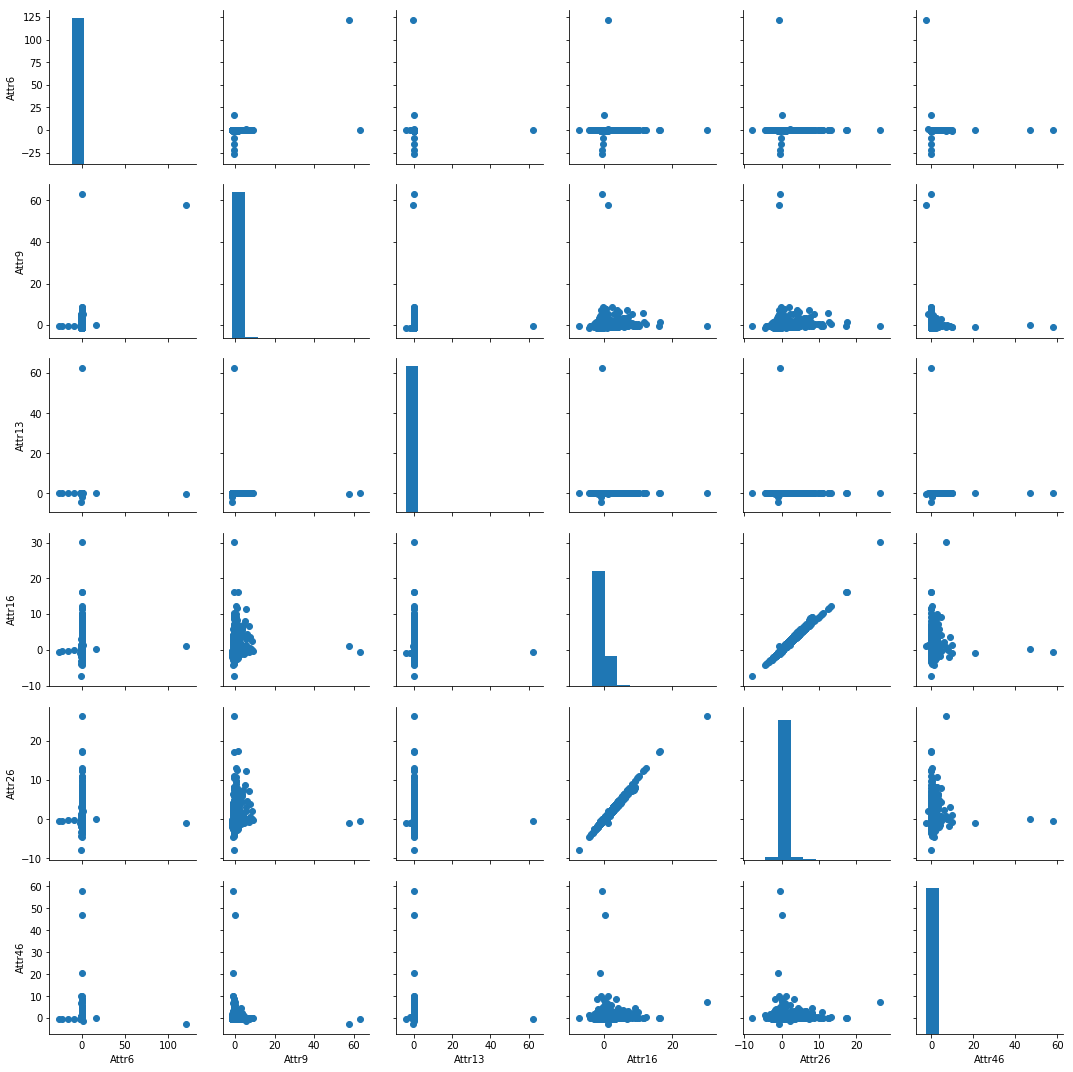

In [11]:
pg = plot_pairgrid(bankruptcy_train)

##### Although bankruptcy companies may have higher sales, however, they usually have lower profitability.

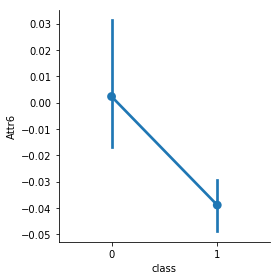

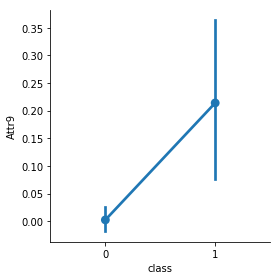

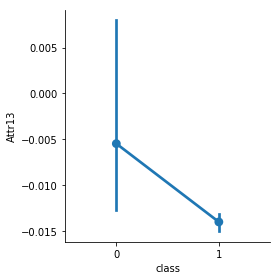

In [12]:
#Attr6	retained earnings / total assets
sns.factorplot('class','Attr6',data=bankruptcy_train,size=4)

#Attr9	sales / total assets
sns.factorplot('class','Attr9',data=bankruptcy_train,size=4)

#Attr13	(gross profit + depreciation) / sales
sns.factorplot('class','Attr13',data=bankruptcy_train,size=4)

##### Bankruptcy companies usually have lower liquidity.

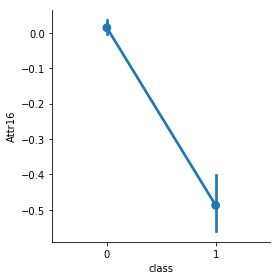

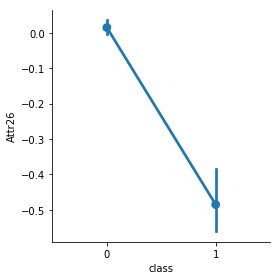

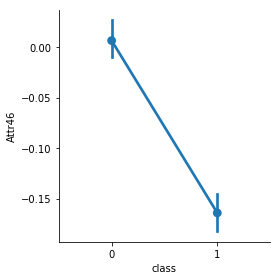

In [13]:
#Attr16	(gross profit + depreciation) / total liabilities
sns.factorplot('class','Attr16',data=bankruptcy_train,size=4)

#Attr26	(net profit + depreciation) / total liabilities
sns.factorplot('class','Attr26',data=bankruptcy_train,size=4)

#Attr46	(current assets - inventory) / short-term liabilities
sns.factorplot('class','Attr46',data=bankruptcy_train,size=4)

### SMOTE to deal with imbalance data

In [14]:
X=bankruptcy_train.iloc[:,0:48]
y=bankruptcy_train.iloc[:,48]
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (10000, 48)
Shape of y: (10000,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (7000, 48)
Number transactions y_train dataset:  (7000,)
Number transactions X_test dataset:  (3000, 48)
Number transactions y_test dataset:  (3000,)


In [16]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 130
Before OverSampling, counts of label '0': 6870 

After OverSampling, the shape of train_X: (13740, 48)
After OverSampling, the shape of train_y: (13740,) 

After OverSampling, counts of label '1': 6870
After OverSampling, counts of label '0': 6870


### Logistic Regression Model

In [17]:
lr = LogisticRegression()
# tuning the parameters
parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   14.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [18]:
clf.best_params_

{'C': 2.0}

In [19]:
lr1 = LogisticRegression(C=2,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res)

[LibLinear]

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=5, warm_start=False)

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 86.15384615384616%


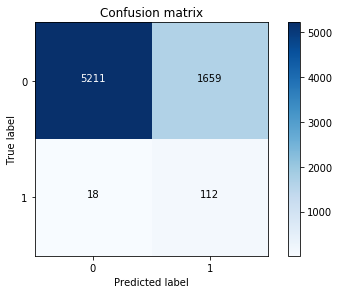

In [21]:
y_train_pre = lr1.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 83.56164383561644%


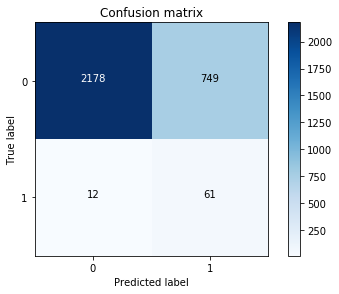

In [22]:
y_pre = lr1.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [23]:
lr_accuracy_score_smote = metrics.accuracy_score(y_test, y_pre)
print("Logistic Regression Accuracy:", lr_accuracy_score_smote)

lr_precision_score_smote = metrics.precision_score(y_test, y_pre)
print("Logistic Regression Precision:", lr_precision_score_smote)

lr_recall_score_smote = metrics.recall_score(y_test, y_pre)
print("Logistic Regression Recall:", lr_recall_score_smote)

Logistic Regression Accuracy: 0.7463333333333333
Logistic Regression Precision: 0.07530864197530865
Logistic Regression Recall: 0.8356164383561644


In [24]:
print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85      2927
           1       0.08      0.84      0.14        73

   micro avg       0.75      0.75      0.75      3000
   macro avg       0.53      0.79      0.49      3000
weighted avg       0.97      0.75      0.83      3000



### Decision Tree Classifier Model

In [25]:
dt = DecisionTreeClassifier()
# tuning the parameters
parameters = {'max_depth': [2,3,4,5], 'min_samples_leaf':[0.04,0.06,0.08,0.1]}
dt = GridSearchCV(dt, parameters, cv=5)
dt.fit(X_train_res, y_train_res)
dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 0.04}

In [26]:
dt1 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 0.04) 
dt1.fit(X_train_res, y_train_res)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.04, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Recall metric in the train dataset: 83.84615384615384%


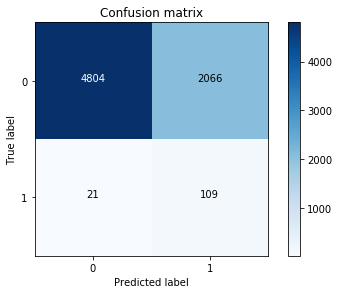

In [27]:
y_train_pre = dt1.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 71.23287671232876%


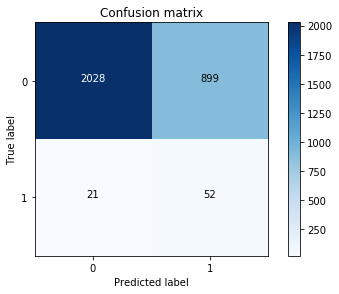

In [28]:
y_pre = dt1.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [29]:
dt_accuracy_score_smote = metrics.accuracy_score(y_test, y_pre)
print("Decision Tree Classifier Accuracy:", dt_accuracy_score_smote)

dt_precision_score_smote = metrics.precision_score(y_test, y_pre)
print("Decision Tree Classifier Precision:", dt_precision_score_smote)

dt_recall_score_smote = metrics.recall_score(y_test, y_pre)
print("Decision Tree Classifier Recall:", dt_recall_score_smote)

Decision Tree Classifier Accuracy: 0.6933333333333334
Decision Tree Classifier Precision: 0.054679284963196635
Decision Tree Classifier Recall: 0.7123287671232876


### Random Forest Classifier Model

In [30]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Recall metric in the train dataset: 100.0%


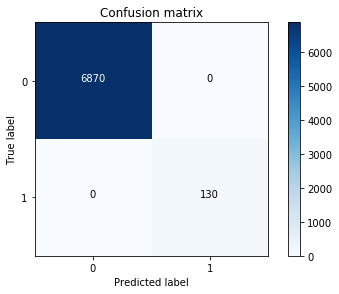

In [31]:
y_train_pre = rf.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 15.068493150684931%


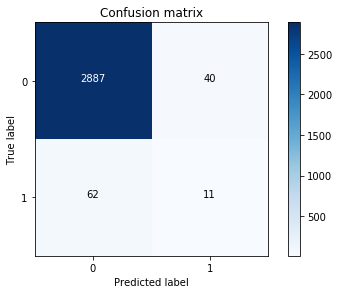

In [32]:
y_pre = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [33]:
rf_accuracy_score_smote = metrics.accuracy_score(y_test, y_pre)
print("Random Forest Classifier Accuracy:", rf_accuracy_score_smote)

rf_precision_score_smote = metrics.precision_score(y_test, y_pre)
print("Random Forest Classifier Precision:", rf_precision_score_smote)

rf_recall_score_smote = metrics.recall_score(y_test, y_pre)
print("Random Forest Classifier Recall:", rf_recall_score_smote)

Random Forest Classifier Accuracy: 0.966
Random Forest Classifier Precision: 0.21568627450980393
Random Forest Classifier Recall: 0.1506849315068493


In [34]:
# Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(10)

,importance
feature,
Attr26,0.060
Attr13,0.050
Attr6,0.050
Attr16,0.046
Attr9,0.036
Attr46,0.034
Attr2,0.028
Attr17,0.025
Attr15,0.023


### Just for fun! How SMOTE technique improved the model? What if we just use the original dataset?
##### We are using the similar logic as above but with the original dataset, where SMOTE was not applied.

##### Logistic Regression Model - no smote

In [35]:
lr3 = LogisticRegression()
# tuning the parameters
parameters = {'C': np.linspace(1, 10, 10)}
clf = GridSearchCV(lr3, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [36]:
clf.best_params_

{'C': 8.0}

In [37]:
lr4 = LogisticRegression(C=8,penalty='l1', verbose=5)
lr4.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=5, warm_start=False)

In [38]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 0.7692307692307693%


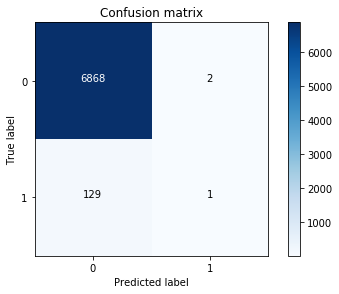

In [39]:
y_train_pre = lr4.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 0.0%


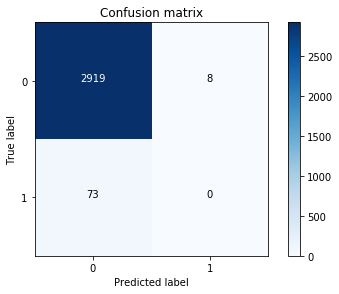

In [40]:
y_pre = lr4.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [41]:
lr_accuracy_score_nosmote = metrics.accuracy_score(y_test, y_pre)
print("Logistic Regression Accuracy (no smote):", lr_accuracy_score_nosmote)

lr_precision_score_nosmote = metrics.precision_score(y_test, y_pre)
print("Logistic Regression Precision (no smote):", lr_precision_score_nosmote)

lr_recall_score_nosmote = metrics.recall_score(y_test, y_pre)
print("Logistic Regression Recall (no smote):", lr_recall_score_nosmote)

Logistic Regression Accuracy (no smote): 0.973
Logistic Regression Precision (no smote): 0.0
Logistic Regression Recall (no smote): 0.0


##### Decision Tree Classifier Model - no smote 

In [42]:
dt3 = DecisionTreeClassifier()
# tuning the parameters
parameters = {'max_depth': [2,3,4,5], 'min_samples_leaf':[0.04,0.06,0.08,0.1]}
dt3 = GridSearchCV(dt3, parameters, cv=5)
dt3.fit(X_train, y_train)
dt3.best_params_

{'max_depth': 2, 'min_samples_leaf': 0.04}

In [43]:
dt4 = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 0.04) 
dt4.fit(X_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.04, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Recall metric in the train dataset: 0.0%


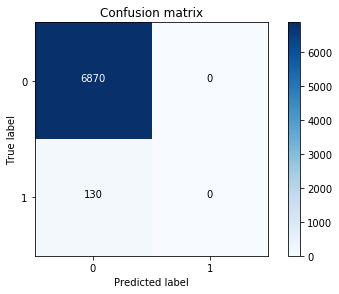

In [44]:
y_train_pre = dt4.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 0.0%


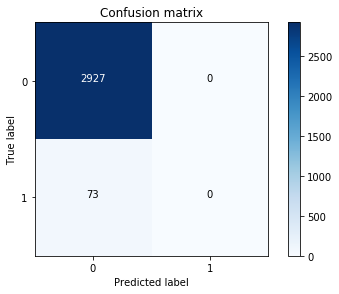

In [45]:
y_pre = dt4.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [46]:
dt_accuracy_score_nosmote = metrics.accuracy_score(y_test, y_pre)
print("Decision Tree Classifier Accuracy (no smote):", dt_accuracy_score_nosmote)

dt_precision_score_nosmote = metrics.precision_score(y_test, y_pre)
print("Decision Tree Classifier Precision (no smote):", dt_precision_score_nosmote)

dt_recall_score_nosmote = metrics.recall_score(y_test, y_pre)
print("Decision Tree Classifier Recall (no smote):", dt_recall_score_nosmote)

Decision Tree Classifier Accuracy (no smote): 0.9756666666666667
Decision Tree Classifier Precision (no smote): 0.0
Decision Tree Classifier Recall (no smote): 0.0


##### Random Forest Classifier Model - no smote

In [47]:
rf2 = RandomForestClassifier(n_estimators=500)
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Recall metric in the train dataset: 100.0%


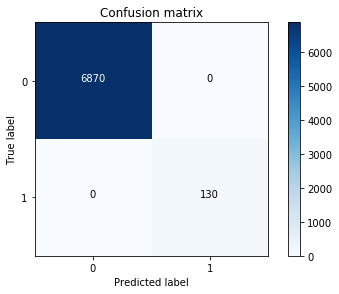

In [48]:
y_train_pre = rf2.predict(X_train)
cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 1.36986301369863%


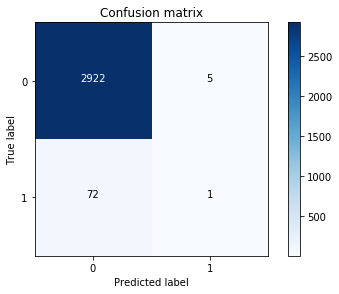

In [49]:
y_pre = rf2.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [50]:
rf_accuracy_score_nosmote = metrics.accuracy_score(y_test, y_pre)
print("Random Forest Classifier Accuracy (no smote):", rf_accuracy_score_nosmote)

rf_precision_score_nosmote = metrics.precision_score(y_test, y_pre)
print("Random Forest Classifier Precision (no smote):", rf_precision_score_nosmote)

rf_recall_score_nosmote = metrics.recall_score(y_test, y_pre)
print("Random Forest Classifier Recall (no smote):", rf_recall_score_nosmote)

Random Forest Classifier Accuracy (no smote): 0.9743333333333334
Random Forest Classifier Precision (no smote): 0.16666666666666666
Random Forest Classifier Recall (no smote): 0.0136986301369863


In [51]:
# Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf2.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(10)

,importance
feature,
Attr46,0.039
Attr9,0.030
Attr56,0.028
Attr40,0.026
Attr26,0.026
Attr16,0.025
Attr20,0.024
Attr60,0.023
Attr15,0.023


### Compare models & Findings

In [52]:
models_nosmote = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree Classifier','Random Forest Classifier',],
    'Accuracy score': [lr_accuracy_score_nosmote, dt_accuracy_score_nosmote, rf_accuracy_score_nosmote],
    'Precision': [lr_precision_score_nosmote, dt_precision_score_nosmote, rf_precision_score_nosmote],
    'Recall': [lr_recall_score_nosmote, dt_recall_score_nosmote, rf_recall_score_nosmote]})

models_nosmote.sort_values(by='Recall', ascending=False)

,Model,Accuracy score,Precision,Recall
2,Random Forest Classifier,0.974333,0.166667,0.013699
0,Logistic Regression,0.973000,0.000000,0.000000
1,Decision Tree Classifier,0.975667,0.000000,0.000000


In [53]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree Classifier','Random Forest Classifier',],
    'Accuracy score': [lr_accuracy_score_smote, dt_accuracy_score_smote, rf_accuracy_score_smote],
    'Precision': [lr_precision_score_smote, dt_precision_score_smote, rf_precision_score_smote],
    'Recall': [lr_recall_score_smote, dt_recall_score_smote, rf_recall_score_smote]})

models.sort_values(by='Recall', ascending=False)

,Model,Accuracy score,Precision,Recall
0,Logistic Regression,0.746333,0.075309,0.835616
1,Decision Tree Classifier,0.693333,0.054679,0.712329
2,Random Forest Classifier,0.966000,0.215686,0.150685


#### 1. The models were imporved a lot after SMOTE technique applied.
#### 2. We believe "Recall" is more important than "Precision" and "Accuracy" in this case, because our purpose is to narrow down the list of companies which might be bankruptcy. We would like to identify the companies which need further track or investigation.
#### 3. Although the "Random Forest Classifier" has the highest accuracy score, its recall score is low.
#### 4. After comparing recall score, the "Logistic Regression" model is the best. We are going to apply Logistic Regression to the Fundamental.csv (Please see below).

## Apply model - using Fundamental.csv

In [54]:
data=pd.read_csv("fundamentals.csv")

In [55]:
data.shape

(1781, 79)

In [56]:
data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


### Clean data

In [57]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [58]:
pd.options.mode.use_inf_as_na = True

In [59]:
# Added new columns Attr1 - 64 (except for the dropped attributes) to based on the formulas behind each attributes.
data['Attr1'] = data['Net Income']/data['Total Assets']
data['Attr2'] = data['Total Liabilities']/data['Total Assets']
data['Attr3'] = (data['Total Current Assets']-data['Total Current Liabilities'])/data['Total Assets']
data['Attr4'] = data['Total Current Assets']/data['Total Current Liabilities']
data['Attr6'] = data['Retained Earnings']/data['Total Assets']
data['Attr7'] = data['Earnings Before Interest and Tax']/data['Total Assets']
data['Attr8'] = (data['Total Assets']-data['Total Liabilities'])/data['Total Liabilities']
data['Attr9'] = data['Total Revenue']/data['Total Assets']
data['Attr10'] = data['Total Equity']/data['Total Assets']
data['Attr12'] = data['Gross Profit']/data['Total Current Liabilities']
data['Attr13'] = (data['Gross Profit']+data['Depreciation'])/data['Total Revenue']
data['Attr14'] = (data['Gross Profit']+data['Interest Expense'])/data['Total Assets']
data['Attr15'] = (data['Total Liabilities']*365)/(data['Gross Profit']+data['Depreciation'])
data['Attr16'] = (data['Gross Profit']+data['Depreciation'])/data['Total Liabilities']
data['Attr17'] = data['Total Assets']/data['Total Liabilities']
data['Attr18'] = data['Gross Profit']/data['Total Assets']
data['Attr19'] = data['Gross Profit']/data['Total Revenue']
data['Attr20'] = (data['Inventory']*365)/data['Total Revenue']
data['Attr22'] = data['Operating Income']/data['Total Assets']
data['Attr23'] = data['Net Income']/data['Total Revenue']
data['Attr26'] = (data['Net Income']+data['Depreciation'])/data['Total Liabilities']
data['Attr28'] = (data['Total Current Assets']-data['Total Current Liabilities'])/data['Fixed Assets']
data['Attr30'] = (data['Total Liabilities']-data['Cash and Cash Equivalents'])/data['Total Revenue']
data['Attr31'] = (data['Gross Profit']+data['Interest Expense'])/data['Total Revenue']
data['Attr32'] = (data['Total Current Liabilities']*365)/data['Cost of Revenue']
data['Attr36'] = data['Total Revenue']/data['Total Assets']
data['Attr37'] = (data['Total Current Assets']-data['Inventory'])/data['Long-Term Debt']
data['Attr40'] = (data['Total Current Assets']-data['Inventory']-data['Accounts Receivable'])/data['Total Current Liabilities']
data['Attr41'] = data['Total Liabilities']/((data['Operating Income']+data['Depreciation']) *12/365)
data['Attr42'] = data['Operating Income']/data['Total Revenue']
data['Attr44'] = (data['Accounts Receivable']*365)/data['Total Revenue']
data['Attr45'] = data['Net Income']/data['Inventory']
data['Attr46'] = (data['Total Current Assets']-data['Inventory'])/data['Total Current Liabilities']
data['Attr47'] = (data['Inventory']*365)/data['Cost of Revenue']
data['Attr48'] = (data['Operating Income']-data['Depreciation'])/data['Total Assets']
data['Attr49'] = (data['Operating Income']-data['Depreciation'])/data['Total Revenue']
data['Attr50'] = data['Total Current Assets']/data['Total Liabilities']
data['Attr51'] = data['Total Current Liabilities']/data['Total Assets']
data['Attr52'] = (data['Total Current Liabilities']*365)/data['Cost of Revenue']
data['Attr53'] = data['Total Equity']/data['Fixed Assets']
data['Attr56'] = (data['Total Revenue']-data['Cost of Revenue'])/data['Total Revenue']
data['Attr57'] = (data['Total Current Assets']-data['Inventory']-data['Total Current Liabilities'])/(data['Total Revenue']-data['Gross Profit']-data['Depreciation'])
data['Attr59'] = data['Long-Term Debt']/data['Total Equity']
data['Attr60'] = data['Total Revenue']/data['Inventory']
data['Attr61'] = data['Total Revenue']/data['Accounts Receivable']
data['Attr62'] = (data['Total Current Liabilities']*365)/data['Total Revenue']
data['Attr63'] = data['Total Revenue']/data['Total Current Liabilities']
data['Attr64'] = data['Total Revenue']/data['Fixed Assets']

In [60]:
data.shape

(1781, 126)

In [61]:
x_fundamental=data.iloc[:,78:126]
x_fundamental['Ticker Symbol']=data['Ticker Symbol']

In [62]:
x_fundamental.head()

,Attr1,Attr2,Attr3,Attr4,Attr6,Attr7,Attr8,Attr9,Attr10,Attr12,...,Attr53,Attr56,Attr57,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,Ticker Symbol
0,-0.079796,1.058741,-0.082476,0.784819,-0.402467,-0.077116,-0.055482,1.057210,-0.339728,1.593164,...,-0.595956,0.577590,-0.265214,-0.890948,42.853448,-111.959459,132.328103,2.758295,1.854574,AAL
1,-0.043380,1.064596,0.012229,1.037447,-0.267184,-0.031317,-0.060677,0.632551,-0.064596,1.138925,...,-0.141804,0.587967,-0.049505,-5.621750,26.425889,-287.559140,188.430243,1.937056,1.388598,AAL
2,0.066674,0.953245,-0.038265,0.876604,-0.198080,0.094829,0.049049,0.986698,0.046755,2.016562,...,0.087550,0.633763,-0.186161,7.938149,42.480080,-266.562500,114.711841,3.181886,1.847600,AAL
3,0.157183,0.883610,-0.074770,0.733921,-0.025405,0.113519,0.131720,0.846638,0.116390,2.197280,...,0.204835,0.729300,-0.466542,3.252884,47.497103,116.448864,121.147231,3.012863,1.490004,AAL
4,0.084024,0.737594,0.135368,1.244004,0.154948,0.142597,0.355760,1.344875,0.262406,1.210341,...,0.936673,0.499280,-0.577238,0.499268,2.687767,-69.343589,150.566868,2.424172,4.800601,AAP


In [63]:
x_fundamental.shape

(1781, 49)

In [64]:
x_fundamental.isnull().sum()

Attr1              0
Attr2              0
Attr3              0
Attr4            299
Attr6              0
Attr7              0
Attr8              0
Attr9              0
Attr10             0
Attr12           299
Attr13             0
Attr14             0
Attr15             0
Attr16             0
Attr17             0
Attr18             0
Attr19             0
Attr20             0
Attr22             0
Attr23             0
Attr26             0
Attr28            51
Attr30             0
Attr31             0
Attr32           107
Attr36             0
Attr37           156
Attr40           299
Attr41             0
Attr42             0
Attr44             0
Attr45           550
Attr46           299
Attr47           107
Attr48             0
Attr49             0
Attr50             0
Attr51             0
Attr52           107
Attr53            51
Attr56             0
Attr57             0
Attr59             0
Attr60           550
Attr61           193
Attr62             0
Attr63           299
Attr64       

In [65]:
# Drop rows with missing values since the missing amount is less than 30%.
x_fundamental = x_fundamental.dropna(subset=['Attr4'])
x_fundamental = x_fundamental.dropna(subset=['Attr12'])
x_fundamental = x_fundamental.dropna(subset=['Attr28'])
x_fundamental = x_fundamental.dropna(subset=['Attr32'])
x_fundamental = x_fundamental.dropna(subset=['Attr37'])
x_fundamental = x_fundamental.dropna(subset=['Attr40'])
x_fundamental = x_fundamental.dropna(subset=['Attr45'])
x_fundamental = x_fundamental.dropna(subset=['Attr46'])
x_fundamental = x_fundamental.dropna(subset=['Attr47'])
x_fundamental = x_fundamental.dropna(subset=['Attr52'])
x_fundamental = x_fundamental.dropna(subset=['Attr53'])
x_fundamental = x_fundamental.dropna(subset=['Attr60'])
x_fundamental = x_fundamental.dropna(subset=['Attr61'])
x_fundamental = x_fundamental.dropna(subset=['Attr63'])
x_fundamental = x_fundamental.dropna(subset=['Attr64'])

### Predicting bankruptcy

In [66]:
x_fundamental_1=x_fundamental.iloc[:,0:48]
x_fundamental_1.head()

,Attr1,Attr2,Attr3,Attr4,Attr6,Attr7,Attr8,Attr9,Attr10,Attr12,...,Attr52,Attr53,Attr56,Attr57,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,-0.079796,1.058741,-0.082476,0.784819,-0.402467,-0.077116,-0.055482,1.057210,-0.339728,1.593164,...,313.269359,-0.595956,0.577590,-0.265214,-0.890948,42.853448,-111.959459,132.328103,2.758295,1.854574
1,-0.043380,1.064596,0.012229,1.037447,-0.267184,-0.031317,-0.060677,0.632551,-0.064596,1.138925,...,457.318268,-0.141804,0.587967,-0.049505,-5.621750,26.425889,-287.559140,188.430243,1.937056,1.388598
2,0.066674,0.953245,-0.038265,0.876604,-0.198080,0.094829,0.049049,0.986698,0.046755,2.016562,...,313.217670,0.087550,0.633763,-0.186161,7.938149,42.480080,-266.562500,114.711841,3.181886,1.847600
3,0.157183,0.883610,-0.074770,0.733921,-0.025405,0.113519,0.131720,0.846638,0.116390,2.197280,...,447.532895,0.204835,0.729300,-0.466542,3.252884,47.497103,116.448864,121.147231,3.012863,1.490004
4,0.084024,0.737594,0.135368,1.244004,0.154948,0.142597,0.355760,1.344875,0.262406,1.210341,...,300.700931,0.936673,0.499280,-0.577238,0.499268,2.687767,-69.343589,150.566868,2.424172,4.800601


In [67]:
y_bankruptcy_pred = lr1.predict(x_fundamental_1)
x_fundamental['bankruptcy'] = y_bankruptcy_pred

In [68]:
x_fundamental.groupby('bankruptcy').Attr1.count()

bankruptcy
0    1048
1      26
Name: Attr1, dtype: int64

In [69]:
x_fundamental_bankruptcy = x_fundamental[x_fundamental['bankruptcy'] == 1]

In [70]:
list1=x_fundamental_bankruptcy['Ticker Symbol']

In [71]:
list1.value_counts()

CVX     3
KMX     3
SYY     2
BDX     2
KR      2
SWK     1
TJX     1
GIS     1
CTAS    1
WFM     1
WMT     1
GWW     1
BBY     1
MKC     1
MO      1
PWR     1
JBHT    1
HD      1
PSX     1
Name: Ticker Symbol, dtype: int64

### Conslusion

##### We narrowed down list of companies which might be bankruptcy and need further track or investigation. Here is the final company list:
##### KMX (CarMax), CVX (Chevron Corporation), BDX (Becton Dickinson), KR (Kroger), TJX (TJX Companies), SYY (Sysco), MKC (McCormick & Company), WFM (Whole Foods Market), PWR (Quanta Services), BBY (Best Buy), SWK (Stanley Black & Decker, Inc.), PSX (Phillips 66), GWW (W. W. Grainger), XRAY (DENTSPLY SIRONA), MO (Altria Group), GIS (General Mills), XOM (ExxonMobil), WMT (Walmart Inc), CTAS (Cintas), JBHT (J. B. Hunt), HD (The Home Depot).
